# E-Commerce. Онлайн-продажи товаров

RFM-сегментация, когортный анализ, разведывательный анализ, python, pandas, seaborn и др  

Данные, содержащиеся в работе искусственны / были изменены

### Задачи и вопросы, на которые нужно было ответить при помощи анализа данных:

#### 1. Сколько  пользователей, совершивших покупку только один раз?

#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

#### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

#### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

#### 5. Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц. 

#### 6. Провести RFM-анализ пользователей. R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. 


Файлы:

#### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя  


#### olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки  


#### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён


In [1]:
import pandas as pd # импортируем библиотеки
import numpy as np
import seaborn as sns
import datetime as dt
from operator import attrgetter
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def reader(path):                           # ф-ия для прочтения файла и выборки топ 5 строк
    return pd.read_csv(path).head()

Посмотрим на данные

In [3]:
reader('olist_customers_dataset.csv')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
reader('olist_orders_dataset.csv')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
reader('olist_order_items_dataset.csv')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Запишем датасеты в переменную

In [6]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders    = pd.read_csv('olist_orders_dataset.csv')
items     = pd.read_csv('olist_order_items_dataset.csv')

## Приступим к предварительному изучению данных   
## (непосредственное выполнение заданий начинается на 58-ом шаге)

Посмотрим количество строк

In [7]:
a = [customers, orders, items] # список с таблицами

print('customers =', a[0].shape[0])
print('orders =', a[1].shape[0])
print('items =', a[2].shape[0])

customers = 99441
orders = 99441
items = 112650


Предварительно проверим, есть ли полные дубликаты в каждой из таблиц

In [8]:
for i in a:
    print(i.duplicated().sum()) # полных дубликатов нет

0
0
0


Посмотрим, есть ли в трех таблицах NaN, а ниже - какой процент NaN

In [9]:
for i in a:
    print(i.isna().sum())

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64


In [10]:
for i in a:
    print(i.isna().mean())

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001609
order_delivered_carrier_date     0.017930
order_delivered_customer_date    0.029817
order_estimated_delivery_date    0.000000
dtype: float64
order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64


Посмотрим типы данных в столбцах.  
Вывод: Отмечаем, что многие столбцы с датами воспроизвелись как object.

In [11]:
def typeee(x): # функция для проверки типов строк
    return print(x.dtypes)

typeee(customers)

typeee(orders)

typeee(items)

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object


### Рассмотрим таблицу customers

Проверим, действительно ли позаказный номер заказчика индивидуален для каждого заказа.  
Вывод: Да, количество уникальных позаказных номеров равно количеству строк в таблице

In [12]:
customers['customer_id'].nunique() == customers.shape[0]

True

Проверим, сколько уникальных пользователей и сравним их количество с общим количеством строк в таблице

In [13]:
customers['customer_unique_id'].nunique()

96096

In [14]:
customers['customer_id'].nunique() - customers['customer_unique_id'].nunique()

3345

Предварительный  вывод:

Учитывая, что таблица с покупателями и таблица с заказами имеют одинаковое количество строк, а также то, что они имеют связь по "показазному id", при том, что разница между позаказными id и присвоенными id всего 3345, очевидно, что покупатели редко делают более одного заказа

In [15]:
vc = customers['customer_unique_id'].value_counts().copy() # df с количеством заказом по каждому покупателю

In [16]:
vc = vc.to_frame().query('customer_unique_id > 1')
vc.shape[0]

2997

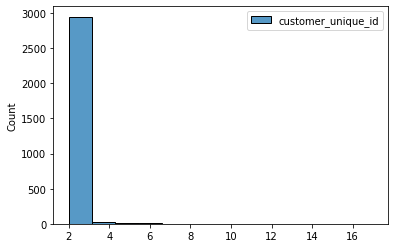

In [17]:
sns.histplot(vc) # гистограмма "сколько раз совершил заказ каждый пользователь"

Предварительно узнаем, что >=2 покупки совершили только 2 997 человек

### Рассмотрим таблицу orders

Посмотрим, сколько было индивидуальных заказов  
Вывод: Каждый заказ в таблице индивидуален

In [18]:
orders.order_id.nunique() == orders.shape[0]

True

Посмотрим, уникальны ли позаказные id покупателей  
Вывод: да, позаказные

In [19]:
orders.customer_id.nunique() == orders.shape[0]

True

Посмотрим статус заказов:  
Вывод: в основном все доставлено. Чуть больше процента отгружено со склада. Далее еще более редкие события

In [20]:
orders['order_status'].value_counts(normalize = True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

ранее мы выяснили, что даты отметились как object. Приведем столбцы с датами к нужному нам типу. Создадим копии столбцов, где будет только дата без времени

In [21]:
orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', # переведем в дату со временем
        'order_delivered_customer_date', 'order_estimated_delivery_date']] = \
orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
        'order_delivered_customer_date', 'order_estimated_delivery_date']] \
.apply(pd.to_datetime, format = '%Y-%m-%d %H:%M:%S')

orders[['order_purchase_timestamp_f', 'order_approved_at_f', 'order_delivered_carrier_date_f', # создадим копии столбцов 
        'order_delivered_customer_date_f', 'order_estimated_delivery_date_f']] = \
orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
        'order_delivered_customer_date', 'order_estimated_delivery_date']]

orders['order_purchase_timestamp_f'] = orders['order_purchase_timestamp_f'].dt.date # уберем время из созданных столбцов
orders['order_approved_at_f'] = orders['order_approved_at_f'].dt.date
orders['order_delivered_carrier_date_f'] = orders['order_delivered_carrier_date_f'].dt.date
orders['order_delivered_customer_date_f'] = orders['order_delivered_customer_date_f'].dt.date
orders['order_estimated_delivery_date_f'] = orders['order_estimated_delivery_date_f'].dt.date

orders.head(1) # очевидно, order_estimated_delivery_date осталось без времени, потому что везде было 00:00:00


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18


Посмотрим, максимальную, минимальную даты в каждом столбце, а также градацию по датам (без времени) - топ 10 дней по каждому столбцу с датами, и топ 10 "с конца"

In [22]:
def min_max(x):
    return(x.min(), x.max())

In [23]:
print('Время создания заказа:', min_max(orders.order_purchase_timestamp))
print('Время подтверждения оплаты заказа: ', min_max(orders.order_approved_at))
print('Время передачи заказа в логистическую службу: ',min_max(orders.order_delivered_carrier_date))
print('Время доставки заказа :', min_max(orders.order_delivered_customer_date))   # 2018-10-17 будем считать 
print('Обещанная дата доставки :', min_max(orders.order_estimated_delivery_date)) # последней датой таблицы

Время создания заказа: (Timestamp('2016-09-04 21:15:19'), Timestamp('2018-10-17 17:30:18'))
Время подтверждения оплаты заказа:  (Timestamp('2016-09-15 12:16:38'), Timestamp('2018-09-03 17:40:06'))
Время передачи заказа в логистическую службу:  (Timestamp('2016-10-08 10:34:01'), Timestamp('2018-09-11 19:48:28'))
Время доставки заказа : (Timestamp('2016-10-11 13:46:32'), Timestamp('2018-10-17 13:22:46'))
Обещанная дата доставки : (Timestamp('2016-09-30 00:00:00'), Timestamp('2018-11-12 00:00:00'))


In [24]:
                  # Создадим ф-ии для дальнейшего использования (топ 11 с учетом NaN по заказам)
def val_c_max(x):                         
    max = x.value_counts(dropna = False).head(11).to_frame().reset_index() \
           .rename(columns = {'index' : 'date_max_orders'})
    return max

                  # Создадим ф-ии для дальнейшего использования (топ 11 с учетом NaN с конца по заказам)
def val_c_min(y):
    min = y.value_counts(dropna = False).tail(11).to_frame().reset_index() \
           .rename(columns = {'index' : 'date_min_orders'})
    return min

# Дата создания заказа

s = val_c_max(orders['order_purchase_timestamp_f']) \
    .rename(columns = {'order_purchase_timestamp_f' : 'amount_max'}).sort_values(['amount_max', 'date_max_orders'], 
                                                                                 ascending = [False, True]) \
                                                                    .rename(columns = {'amount_max' : 'amount_max_orders'})
ss = val_c_min(orders['order_purchase_timestamp_f']) \
    .rename(columns = {'order_purchase_timestamp_f' : 'amount_min'}).sort_values(['amount_min', 'date_min_orders'],
                                                                                 ascending = [False, True]) \
                                                                    .rename(columns = {'amount_min' : 'amount_min_orders'})
s['w']  = [i for i in range(1, 12)]
ss['w'] = [i for i in range(1, 12)]
sss = s.merge(ss, how = 'inner', on = 'w')


# Дата подтверждения оплаты заказа

d = val_c_max(orders['order_approved_at_f']) \
    .rename(columns = {'order_approved_at_f' : 'amount_max'}).sort_values(['amount_max', 'date_max_orders'], 
                                                                        ascending = [False, True]) \
                                                    .rename(columns = {'date_max_orders' : 'date_max_pay',
                                                    'amount_max' : 'pay_amount_max'})
dd = val_c_min(orders['order_approved_at_f']) \
    .rename(columns = {'order_approved_at_f' : 'amount_min'}).sort_values(['amount_min', 'date_min_orders'], 
                                                                        ascending = [False, True]) \
                                                    .rename(columns = {'date_min_orders' : 'date_min_pay',
                                                    'amount_min' : 'pay_amount_min'})
d['w']  = [i for i in range(1, 12)]
dd['w'] = [i for i in range(1, 12)]
ddd = d.merge(dd, how = 'inner', on = 'w')


# дата передачи заказа в логистическую службу

f = val_c_max(orders['order_delivered_carrier_date_f']) \
    .rename(columns = {'order_delivered_carrier_date_f' : 'amount_max'}).sort_values(['amount_max', 'date_max_orders'], 
                                                                        ascending = [False, True]) \
                                                           .rename(columns = {'date_max_orders' : 'date_max_logistics',
                                                                             'amount_max' : 'logistic_amount_max'})
ff = val_c_min(orders['order_delivered_carrier_date_f']) \
    .rename(columns = {'order_delivered_carrier_date_f' : 'amount_min'}).sort_values(['amount_min', 'date_min_orders'], 
                                                                        ascending = [False, True]) \
                                                           .rename(columns = {'date_min_orders' : 'date_min_logistics',
                                                                             'amount_min' : 'logistic_amount_min'})
f['w']  = [i for i in range(1, 12)]
ff['w'] = [i for i in range(1, 12)]
fff = f.merge(ff, how = 'inner', on = 'w')


# дата доставки заказа
g = val_c_max(orders['order_delivered_customer_date_f']) \
    .rename(columns = {'order_delivered_customer_date_f' : 'amount_max'}).sort_values(['amount_max', 'date_max_orders'], 
                                                                        ascending = [False, True]) \
                                                           .rename(columns = {'date_max_orders' : 'date_max_delivered',
                                                                             'amount_max' : 'delivered_amount_max'})
gg = val_c_min(orders['order_delivered_customer_date_f']) \
    .rename(columns = {'order_delivered_customer_date_f' : 'amount_min'}).sort_values(['amount_min', 'date_min_orders'], 
                                                                        ascending = [False, True]) \
                                                           .rename(columns = {'date_min_orders' : 'date_min_delivered',
                                                                             'amount_min' : 'delivered_amount_min'})
 
g['w']  = [i for i in range(1, 12)]
gg['w'] = [i for i in range(1, 12)]
ggg = g.merge(gg, how = 'inner', on = 'w')


# обещанная дата доставки

h = val_c_max(orders['order_estimated_delivery_date_f']) \
    .rename(columns = {'order_estimated_delivery_date_f' : 'amount_max'}).sort_values(['amount_max', 'date_max_orders'], 
                                                                        ascending = [False, True]) \
                                                           .rename(columns = {'date_max_orders' : 'date_max_promise',
                                                                             'amount_max' : 'promise_amount_max'})
hh = val_c_min(orders['order_estimated_delivery_date_f']) \
    .rename(columns = {'order_estimated_delivery_date_f' : 'amount_min'}).sort_values(['amount_min', 'date_min_orders'], 
                                                                        ascending = [False, True]) \
                                                           .rename(columns = {'date_min_orders' : 'date_min_promise',
                                                                             'amount_min' : 'promise_amount_min'})
h['w']  = [i for i in range(1, 12)]
hh['w'] = [i for i in range(1, 12)]
hhh = h.merge(hh, how = 'inner', on = 'w')


# по дефолту inner join

top_tail = sss.merge(ddd, on = 'w').merge(fff, on = 'w').merge(ggg, on = 'w').merge(hhh, on = 'w')
top_tail = top_tail.drop(columns='w')
top_tail

,date_max_orders,amount_max_orders,date_min_orders,amount_min_orders,date_max_pay,pay_amount_max,date_min_pay,pay_amount_min,date_max_logistics,logistic_amount_max,date_min_logistics,logistic_amount_min,date_max_delivered,delivered_amount_max,date_min_delivered,delivered_amount_min,date_max_promise,promise_amount_max,date_min_promise,promise_amount_min
0,2017-11-24,1176,2016-09-13,1,2018-04-24,990,2018-07-03,5,NaN,1783,2016-11-09,1,NaN,2965,2016-11-14,1,2017-12-20,522,2016-09-30,1
1,2017-11-25,499,2016-10-02,1,2017-11-24,799,2017-01-08,4,2017-11-28,707,2016-11-18,1,2018-08-27,446,2016-12-12,1,2018-03-12,516,2016-10-04,1
2,2017-11-27,403,2016-10-22,1,2017-11-25,754,2017-01-09,4,2017-11-27,673,2016-12-06,1,2018-08-13,442,2016-12-14,1,2018-03-13,513,2016-10-24,1
3,2017-11-26,391,2018-09-12,1,2018-07-05,697,2018-07-22,4,2017-11-29,566,2016-12-27,1,2018-05-14,434,2017-06-04,1,2018-05-29,513,2016-10-28,1
4,2017-11-28,380,2018-09-13,1,2017-11-28,506,2016-10-13,3,2018-02-27,523,2017-04-29,1,2018-05-21,431,2017-06-20,1,2018-02-14,507,2016-11-07,1
5,2018-05-07,372,2018-09-20,1,2018-08-07,444,2016-10-18,3,2018-03-27,511,2017-10-12,1,2018-05-18,425,2017-08-20,1,2017-12-18,493,2016-11-14,1
6,2018-08-06,372,2018-09-25,1,2017-12-05,426,2017-01-05,3,2018-08-06,510,2017-12-10,1,2018-04-11,413,2017-10-29,1,2018-03-06,492,2016-12-19,1
7,2018-08-07,370,2018-09-26,1,2018-05-08,426,2017-01-06,3,2017-11-30,489,2018-02-11,1,2017-12-11,412,2017-11-12,1,2018-05-28,492,2016-12-30,1
8,2018-05-14,364,2018-10-01,1,2018-08-20,426,2016-09-15,1,2018-08-13,472,2018-03-04,1,2018-07-03,410,2018-09-08,1,2018-02-06,491,2017-01-11,1
9,2018-05-16,357,2018-10-16,1,2018-01-22,408,2016-12-23,1,2018-05-15,451,2018-09-03,1,2018-05-03,409,2018-09-11,1,2018-04-12,490,2018-10-11,1


Последнее, на что предварительно посмотрим - в скольки процентах мы опоздали с доставкой. При этом помним, что у нас есть
не мало NaN в данных, но здесь их не учитываем  
Вывод: c 6,5 % заказов опоздали

In [25]:
orders.query('order_delivered_customer_date_f > order_estimated_delivery_date_f').shape[0] / orders.shape[0]

0.06571736004263835

Посмотрим на строки, где NaN в дате передачи заказа покупателю c разными статусами заказа.  
Вывод:  
   Если мы говорим о статусе "доставлен", то если брать за аксому верности статуса, NaT обусловлен каким-то багом;  
   "недоступен" -  ничего не могу пока что сказать;  
   "отменен" - предполагаю, что в данном случае, все корректно отображается. При этом 6 отмен были уже после доставки заказа;  
   "подтвержден" - предполагаю, что в данном случае, все корректно отображается  
   "создан" - предполагаю, что в данном случае, все корректно отображается
   
Остальное не вижу смысл смотреть именно по графе "дата передачи клиенту", потому что оставшиеся и некоторые из проверенных статусы не предполагают, что товар может уже быть передан. Если понадобится для заданий, позже будем анализировать причины NaT в разных столбцах
   

In [26]:
# заказы доставлены
orders.query('order_delivered_customer_date_f.isnull() and order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18,2017-11-28,2017-11-28,2017-11-30,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16,2018-06-20,2018-06-20,2018-06-25,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30,2018-07-01,2018-07-01,2018-07-03,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30,2018-07-01,2018-07-01,2018-07-03,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24,2018-07-01,2018-07-01,2018-07-03,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,2017-05-25,2017-05-25,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26,2018-06-08,2018-06-08,2018-06-12,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19,2018-06-27,2018-06-27,2018-07-03,NaT,2018-07-19


In [27]:
# со статусом "недоступен"
orders.query('order_delivered_customer_date_f.isnull() and order_status == "unavailable"').head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,2017-11-16,2017-11-16,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,2018-01-31,2018-01-31,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,2017-08-14,2017-08-17,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06,2018-01-08,2018-01-09,NaT,NaT,2018-02-06


In [28]:
# со статусом "отменен".
orders.query('order_delivered_customer_date_f.isnull() and order_status == "canceled"').head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,2018-08-04,2018-08-07,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,2018-01-26,2018-01-26,2018-01-29,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23,2018-01-25,2018-01-25,2018-01-26,NaT,2018-02-23
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,2018-08-28,NaT,NaT,NaT,2018-09-12


In [29]:
# кол-во точно известных отменен до фактической доставки
orders.query('order_status == "canceled"').shape[0] - orders.query('order_delivered_customer_date_f.isnull() and order_status == "canceled"').shape[0]

6

In [30]:
# статус "подтвержден"
orders.query('order_delivered_customer_date_f.isnull() and order_status == "approved"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f
44897,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01,2017-02-06,2017-02-06,NaT,NaT,2017-03-01
88457,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22,2017-04-25,2017-04-30,NaT,NaT,2017-05-22


In [31]:
orders.query('order_status == "approved"').shape[0] - orders.query('order_delivered_customer_date_f.isnull() and order_status == "approved"').shape[0]

0

In [32]:
orders.query('order_delivered_customer_date_f.isnull() and order_status == "created"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11,2017-12-05,NaT,NaT,NaT,2018-01-11
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07,2018-02-09,NaT,NaT,NaT,2018-03-07
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12,2017-11-25,NaT,NaT,NaT,2017-12-12
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,2017-12-05,NaT,NaT,NaT,2018-01-08
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01,2017-11-06,NaT,NaT,NaT,2017-12-01


посчитаем среднюю разницу между предполагаемой датой доставки и фактической доставкой.  
Поскольку прогноз указан с учетом времени 00-00-00, остается предположить, что имелось ввиду - что крайний срок 23:59:59 - день "до" указанного или же весь указанный день. Я выберу второй вариант  

Вывод: среднее разница во времени прогноза и времени доставки - 11 дней 4 часа 18 минут. При этом, существуют заказы, где доставка приходит раньше на 146 дней.

In [33]:
orders['diff'] = orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']

In [34]:
orders['diff'].mean() 

Timedelta('11 days 04:17:55.957616401')

In [35]:
orders.query('order_delivered_customer_date < order_estimated_delivery_date').sort_values('diff', ascending = False).head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff
40094,0607f0efea4b566f1eb8f7d3c2397320,a5fbb6579eacbeb02752a143bfe82405,delivered,2018-03-06 09:47:07,2018-03-06 09:55:47,2018-03-07 21:33:39,2018-03-09 23:36:47,2018-08-03,2018-03-06,2018-03-06,2018-03-07,2018-03-09,2018-08-03,146 days 00:23:13
15791,c72727d29cde4cf870d569bf65edabfd,964253ff0e4e08180064764a450e521f,delivered,2017-02-07 18:01:15,2017-02-09 02:50:07,2017-02-10 05:32:55,2017-02-14 14:27:45,2017-07-04,2017-02-07,2017-02-09,2017-02-10,2017-02-14,2017-07-04,139 days 09:32:15
57160,eec7f369423b033e549c02f3c5381205,32cef4bdd6bfa50612d81dc77a93b131,delivered,2018-02-06 20:44:56,2018-02-08 10:10:31,2018-02-15 20:42:12,2018-02-27 16:35:43,2018-07-12,2018-02-06,2018-02-08,2018-02-15,2018-02-27,2018-07-12,134 days 07:24:17
86444,c2bb89b5c1dd978d507284be78a04cb2,6357fffb5704244d552615bbfcea1442,delivered,2017-05-23 22:28:36,2017-05-24 22:35:08,2017-05-29 02:03:28,2017-06-09 13:35:54,2017-10-11,2017-05-23,2017-05-24,2017-05-29,2017-06-09,2017-10-11,123 days 10:24:06


###### Посчитаем средний срок задержек тех заказов, которые пришли позже запланированного.  
Вывод: средняя задержка из тех заказов, которые приходят позже запланированного - 10 дней 10 часов 45 минут (или 9 дней 13 часов 15 минут?). При этом срок задержек может составлять 189 дней.

In [36]:
orders.query('order_delivered_customer_date > order_estimated_delivery_date')['diff'].mean()

Timedelta('-10 days +10:44:49.387121503')

In [37]:
orders.query('order_delivered_customer_date > order_estimated_delivery_date') \
      .sort_values('diff', ascending = True).head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff
55619,1b3190b2dfa9d789e1f14c05b647a14a,d306426abe5fca15e54b645e4462dc7b,delivered,2018-02-23 14:57:35,2018-02-23 15:16:14,2018-02-26 18:49:07,2018-09-19 23:24:07,2018-03-15,2018-02-23,2018-02-23,2018-02-26,2018-09-19,2018-03-15,-189 days +00:35:53
19590,ca07593549f1816d26a572e06dc1eab6,75683a92331068e2d281b11a7866ba44,delivered,2017-02-21 23:31:27,2017-02-23 02:35:15,2017-03-08 13:47:46,2017-09-19 14:36:39,2017-03-22,2017-02-21,2017-02-23,2017-03-08,2017-09-19,2017-03-22,-182 days +09:23:21
11399,47b40429ed8cce3aee9199792275433f,cb2caaaead400c97350c37a3fc536867,delivered,2018-01-03 09:44:01,2018-01-03 10:31:15,2018-02-06 01:48:28,2018-07-13 20:51:31,2018-01-19,2018-01-03,2018-01-03,2018-02-06,2018-07-13,2018-01-19,-176 days +03:08:29
81401,2fe324febf907e3ea3f2aa9650869fa5,65b14237885b3972ebec28c0f7dd2220,delivered,2017-03-13 20:17:10,2017-03-13 20:17:10,2017-03-17 07:23:53,2017-09-19 17:00:07,2017-04-05,2017-03-13,2017-03-13,2017-03-17,2017-09-19,2017-04-05,-168 days +06:59:53


### Рассмотрим таблицу items

Ниже посмотрим количество уникальных order_id, посмотрим, сколько предметов внутри заказа имеют номер 1,2,3...21  
Вывод: уникальных заказов 98666. Соответственно, столько же заказов, где есть хотя бы один предмет. второй предмет есть в 9803 заказах, три - в 2287 заказов и тд.

In [38]:
items.order_id.nunique()

98666

In [39]:
items.query('order_item_id == 1').shape[0]

98666

In [40]:
items.order_item_id.value_counts() # в order_item_id указан порядковый номер вещи внутри заказа. То есть 2 это не кол-во

1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
20        3
16        3
17        3
18        3
19        3
21        1
Name: order_item_id, dtype: int64

Посмотрим на уникальное количество товаров.  
Вывод: учитывая огромное разнообразие товаров, можем сделать вывод, что один и тот же предмет покупают не часто. Максимальное число покупок одного товара - 527 раз, при этом это всего лишь 0.46%  от общего числа покупок.

In [41]:
items.product_id.nunique()

32951

In [42]:
items.product_id.value_counts(normalize = True) # топ 1 - 527 (без normalize = True)

aca2eb7d00ea1a7b8ebd4e68314663af    0.004678
99a4788cb24856965c36a24e339b6058    0.004332
422879e10f46682990de24d770e7f83d    0.004296
389d119b48cf3043d311335e499d9c6b    0.003480
368c6c730842d78016ad823897a372db    0.003444
                                      ...   
695da2d1ee50ae5a8ad2085798a645ad    0.000009
d0c700eaeaa117724b74c5a327f945ce    0.000009
94f8c822a2c9d476088ac45227f8226c    0.000009
658675929f516ce89c6c508269123f98    0.000009
6a61a5d77a8571a0646e8c0f75f572f4    0.000009
Name: product_id, Length: 32951, dtype: float64

Посмотрим информацию по поставщикам.  
Вывод: уникальных поставщиков - 3095, максимальная продажа - 2033 единиц товара у одного из поставщиков. Максимальное количество уникальных товаров, проданных одним поставщиком - 399 уникальных товаров. Странно, но у одного и того же товара могут быть разные производители. Максимальное число уникальных производителей на один и тот же товар - 8.

In [43]:
items.seller_id.nunique() # кол-во поставщиков

3095

In [44]:
items.seller_id.value_counts() # максимально часто встречающийся производитель купленных товаров - проданы 2033 вещи (не уникальные)

6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
                                    ... 
376d67b61dce0c990155286e7ae486a4       1
c13ef0cfbe42f190780f621ce81f2234       1
4e92348462c75b6c842b994ce84a0ed4       1
5e106d93b717c2682b9383da480364a1       1
b5f0712d22a873b6797ab6cc65c3fcba       1
Name: seller_id, Length: 3095, dtype: int64

In [45]:
                    #количество уникальных проданных предметов на каждого производителя

items.groupby('seller_id', as_index = False) \
     .agg(count_uniq_product = ('product_id', 'nunique')) \
     .sort_values('count_uniq_product', ascending = False)

,seller_id,count_uniq_product
881,4a3ca9315b744ce9f8e9374361493884,399
2485,cca3071e3e9bb7d12640c9fbe2301306,322
2617,d91fb3b7d041e83b64a00a3edfb37e4f,315
3024,fa1c13f2614d7b5c4749cbc52fecda94,289
1391,7142540dd4c91e2237acb7e911c4eba2,266
...,...,...
1704,8b181ee5518df84f18f4e1a43fe07923,1
1703,8b11118053756a9a2932f447e11fc1b5,1
1691,8a1ff5c35f6595a73fef4c7b96e4908a,1
1686,89d9a386b0b6e5fc8403071b03f7206a,1


In [46]:
                                                # есть ли у одного и того же товара разные производители. 
                                                # как ни  странно - есть.
items.groupby('product_id', as_index = False) \
     .agg(count_uniq_seller_id = ('seller_id', 'nunique')) \
     .sort_values('count_uniq_seller_id', ascending = False)

,product_id,count_uniq_seller_id
27128,d285360f29ac7fd97640bf0baef03de0,8
13626,69455f41626a745aea9ee9164cb9eafd,8
8677,4298b7e67dc399c200662b569563a2b2,7
7131,36f60d45225e60c7da4558b070ce4b60,7
13101,656e0eca68dcecf6a31b8ececfabe3e8,7
...,...,...
11198,562f4fcb4d0fb2cd4b547e42e5bfd2e6,1
11197,562f1e9b58672d3c016b72f43579d118,1
11196,562f0027bf0b43b487536b01b2002a3e,1
11195,562cdf9387a027681e0a59b4202e9a40,1


In [47]:
# столько раз был продан один и тот же товар, но в разбивке на его производителей
items.query('product_id == "d285360f29ac7fd97640bf0baef03de0"').seller_id.value_counts()

2eb70248d66e0e3ef83659f71b244378    57
fa1c13f2614d7b5c4749cbc52fecda94    22
4869f7a5dfa277a7dca6462dcf3b52b2    13
b33e7c55446eabf8fe1a42d037ac7d6d    10
7d13fca15225358621be4086e1eb0964     8
d650b663c3b5f6fb392b6326366efa9a     8
01ed254b9ff8407dfb9d99ba1e17d923     4
7e93a43ef30c4f03f38b393420bc753a     1
Name: seller_id, dtype: int64

In [48]:
items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


Приведем дату к нужному типу

In [49]:
items['shipping_limit_date'] = items['shipping_limit_date'].apply(pd.to_datetime, format = '%Y-%m-%d %H:%M:%S')

Посчитаем сумму каждого заказа и выведем топ 10.  
Вывод: максимальная сумма заказа - 13440 - это почти в два раза больше чем "второе место"

In [50]:
summa = items.groupby('order_id') \
     .agg(sum = ('price', 'sum')) \
     .sort_values('sum', ascending = False).reset_index() \
     

summa.head(10)

,order_id,sum
0,03caa2c082116e1d31e67e9ae3700499,13440.0
1,736e1922ae60d0d6a89247b851902527,7160.0
2,0812eb902a67711a1cb742b3cdaa65ae,6735.0
3,fefacc66af859508bf1a7934eab1e97f,6729.0
4,f5136e38d1a14a4dbd87dff67da82701,6499.0
5,2cc9089445046817a7539d90805e6e5a,5934.6
6,a96610ab360d42a2e5335a3998b4718a,4799.0
7,199af31afc78c699f0dbf71fb178d4d4,4690.0
8,b4c4b76c642808cbe472a32b86cddc95,4599.9
9,8dbc85d1447242f3b127dda390d56e19,4590.0


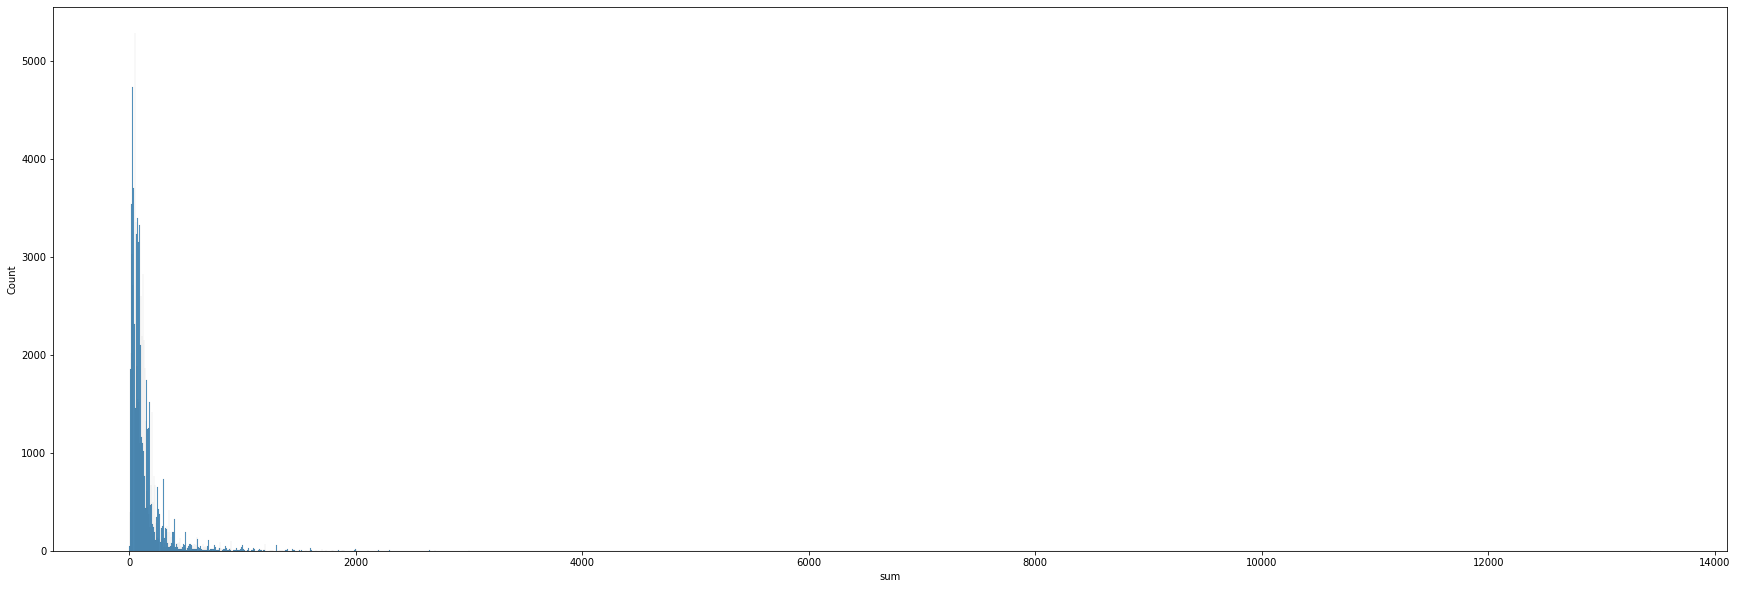

In [51]:
plt.figure(figsize = (30, 10))
sns.histplot(summa['sum']) # видим, что распределение в основном в левой части, но есть очень длинный хвост

In [52]:
summa['sum'].describe()

count    98666.000000
mean       137.754076
std        210.645145
min          0.850000
25%         45.900000
50%         86.900000
75%        149.900000
max      13440.000000
Name: sum, dtype: float64

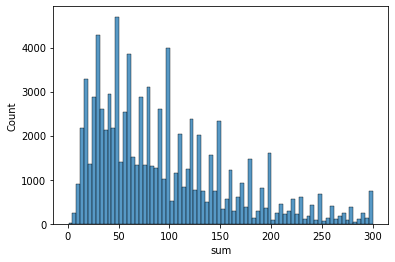

In [53]:
# уберем все, что больше 150 на графике
sns.histplot(summa.query('sum <= 300')['sum'])

In [54]:
summa.query('sum <= 300')['sum'].value_counts()

59.90     1723
69.90     1605
49.90     1420
89.90     1248
99.90     1191
          ... 
279.56       1
139.22       1
250.89       1
125.08       1
117.89       1
Name: sum, Length: 5553, dtype: int64

Создадим по суммам 10 равных по количеству групп, а также добавим процентиль напротив каждого значения

In [55]:
summa['sum_q'] = pd.qcut(summa['sum'], 10)

In [56]:
summa.sum_q.value_counts()

(25.0, 39.0]        9969
(176.96, 269.9]     9909
(67.99, 86.9]       9907
(0.849, 25.0]       9903
(107.0, 134.0]      9860
(50.0, 67.99]       9848
(134.0, 176.96]     9837
(86.9, 107.0]       9828
(269.9, 13440.0]    9823
(39.0, 50.0]        9782
Name: sum_q, dtype: int64

In [57]:
summa['pct'] = summa['sum'].rank(pct=True)
summa

,order_id,sum,sum_q,pct
0,03caa2c082116e1d31e67e9ae3700499,13440.00,"(269.9, 13440.0]",1.000000
1,736e1922ae60d0d6a89247b851902527,7160.00,"(269.9, 13440.0]",0.999990
2,0812eb902a67711a1cb742b3cdaa65ae,6735.00,"(269.9, 13440.0]",0.999980
3,fefacc66af859508bf1a7934eab1e97f,6729.00,"(269.9, 13440.0]",0.999970
4,f5136e38d1a14a4dbd87dff67da82701,6499.00,"(269.9, 13440.0]",0.999959
...,...,...,...,...
98661,38bcb524e1c38c2c1b60600a80fc8999,2.90,"(0.849, 25.0]",0.000051
98662,e8bbc1d69fee39eee4c72cb5c969e39d,2.29,"(0.849, 25.0]",0.000041
98663,f1d5c2e6867fa93ceee9ef9b34a53cbf,2.20,"(0.849, 25.0]",0.000030
98664,3ee6513ae7ea23bdfab5b9ab60bffcb5,0.85,"(0.849, 25.0]",0.000015


# Приступаем к заданиям:
### 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

под покупкой я буду принимать заказ, который не имеет NaN в 'order_approved_at (время подтверждения оплаты), при этом 'order_status' (статус заказа):   

1) не 'canceled'(отмена) - т.к данный заказ отменен и деньги, по идее, возвращаются заказчику (есть случаи даже после доставки)  
2) unavailable(недоступен) - с одной стороны, статус позволяет не учитывать такие заказы как покупку, с другой стороны, данные крайне похожи на данные с другими статусами, которые мы включим в качестве покупки. Считаю, раз нам явно не сказали, что здесь "отмена", заказы с данным статусом также можно учитывать в качестве покупки    
3) invoiced (выставлен счёт) - у всех заказов с данным статусом есть время подтверждения оплаты, а далее NaN. Странность в том, что данная таблица, как выяснили ранее, минимум от 2018-10-17 (крайняя дата передачи товара покупателю в таблице), а есть заказы, которые были подтверждены еще в 2017 году и которые также должны были придти еще в 2017 году.  
4) все тоже самое со статусом approved (подтвержден), processing(процесс сборки), shipped (отгрузка со склада).   
5) order_delivered_customer_date (время доставки заказа) - оставляем, т.к товар доставлен и не отменен.
6) статус created не включаем, т.к не было оплаты ни по одному из заказов с таким статусом

Мы можем как считать за покупку все, что соответствует условиям выше (подтвержденное время оплаты), статус заказа не отменен. Однако, считаю необходимым поставить дополнительный фильтр для того, что бы считать заказ покупкой. 
Я из предполагаемой даты доставки вычту подходящую по смыслу статуса дату или последнюю известную дату (наприер, для статуса: "выставлен счет" NaN начинаются с даты передачи заказа в доставку, таким образом мы берем дату подтверждения оплаты и вычитаем ее из даты предположительной доставки). Далее вычисляем максимальную разницу. Допустим, максимальная разница - 20 дней. Если с момента даты оплаты до 2018-10-17 прошло более 20 дней, при этом в дате доставки "NaN" - мы не считаем это покупкой.Такие индивидуальные критерии высчитываются для каждого статуса и даже со статусом unavailable(недоступен) мы можем считать заказ покупкой, при соблюдении указанных условий.


Далее будет наглядное обоснование позиции о том, что считать за покупку:



Джоиним таблицы покупателей и заказов. Inner - потому что у них равное количество строк и customer_id уникальны

In [58]:
# джоиним таблицы (т.к у них равное количество строк и они уникальные - inner, тем более что кол-во строк не изменилось)
cust_ord = customers.merge(orders, how = 'inner', on = 'customer_id')
cust_ord.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16,2017-05-16,2017-05-23,2017-05-25,2017-06-05,10 days 13:24:25
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12,2018-01-12,2018-01-15,2018-01-29,2018-02-06,7 days 11:18:41
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19,2018-05-20,2018-06-11,2018-06-14,2018-06-13,-2 days +06:01:09
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13,2018-03-13,2018-03-27,2018-03-28,2018-04-10,12 days 07:55:35
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29,2018-07-29,2018-07-30,2018-08-09,2018-08-15,5 days 03:04:12


Посмотрим на каждый статус и количество NaN в разных столбцах  

created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён  

In [59]:
# учитывая, что далее даты создания заказа (до оплаты) - все NaN, заказы с данным статусом за покупку не считаем
cust_ord.query('order_status == "created"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff
13047,4ee64f4bfc542546f422da0aeb462853,10d5890ed5e7ec78a7db23b5ac579b17,93025,sao leopoldo,RS,35de4050331c6c644cddc86f4f2d0d64,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,2017-12-05,NaT,NaT,NaT,2018-01-08,NaT
45313,7d61b9f4f216052ba664f22e9c504ef1,161e5b2b4513edb336986a8909218365,87720,paranavai,PR,90ab3e7d52544ec7bc3363c82689965f,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01,2017-11-06,NaT,NaT,NaT,2017-12-01,NaT
51094,964a6df3d9bdf60fe3e7b8bb69ed893a,2e015e68fbfa36910263df5384e8e45c,73401,brasilia,DF,dba5062fbda3af4fb6c33b1e040ca38f,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07,2018-02-09,NaT,NaT,NaT,2018-03-07,NaT
79266,438449d4af8980d107bf04571413a8e7,55fbb57fd54c35a38c80c2a032a6ca6e,15300,general salgado,SP,b5359909123fa03c50bdb0cfed07f098,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11,2017-12-05,NaT,NaT,NaT,2018-01-11,NaT
87242,725e9c75605414b21fd8c8d5a1c2f1d6,355862aa14375fe3950ee04fef9c7a53,22621,rio de janeiro,RJ,7a4df5d8cff4090e541401a20a22bb80,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12,2017-11-25,NaT,NaT,NaT,2017-12-12,NaT


In [60]:
# Заказ подтвержден. При этом оплата состоялась. Учитывая, что таблица минимум от 2018-10-17 - данные кажутся странными
cust_ord.query('order_status == "approved"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff
3567,8886130db0ea6e9e70ba0b03d7c0d286,7b9d52d22310baecad0f9df64872208d,35590,lagoa da prata,MG,a2e4c44360b4a57bdff22f3a4630c173,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01,2017-02-06,2017-02-06,NaT,NaT,2017-03-01,NaT
83450,b2191912d8ad6eac2e4dc3b6e1459515,6a068ccd3a149b5c8ceb4e04c83feb8a,8255,sao paulo,SP,132f1e724165a07f6362532bfb97486e,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22,2017-04-25,2017-04-30,NaT,NaT,2017-05-22,NaT


In [61]:
cust_ord.query('order_status == "invoiced"').shape[0]

314

In [62]:
# везде, где статус "выставлен счет" оплата уже состоялась, но в 314 случаях нет информации по передаче на отправку и доставке
cust_ord.query('order_status == "invoiced"').isna().sum()

customer_id                          0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_id                             0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date       314
order_delivered_customer_date      314
order_estimated_delivery_date        0
order_purchase_timestamp_f           0
order_approved_at_f                  0
order_delivered_carrier_date_f     314
order_delivered_customer_date_f    314
order_estimated_delivery_date_f      0
diff                               314
dtype: int64

In [63]:
# Процесс сборки заказа
cust_ord.query('order_status == "processing"').shape[0]

301

In [64]:
cust_ord.query('order_status == "processing"').isna().sum()

customer_id                          0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_id                             0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date       301
order_delivered_customer_date      301
order_estimated_delivery_date        0
order_purchase_timestamp_f           0
order_approved_at_f                  0
order_delivered_carrier_date_f     301
order_delivered_customer_date_f    301
order_estimated_delivery_date_f      0
diff                               301
dtype: int64

In [65]:
# время передачи заказа в логистическую службу
cust_ord.query('order_status == "shipped"').shape[0]

1107

In [66]:
cust_ord.query('order_status == "shipped"').isna().sum()

customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date      1107
order_estimated_delivery_date         0
order_purchase_timestamp_f            0
order_approved_at_f                   0
order_delivered_carrier_date_f        0
order_delivered_customer_date_f    1107
order_estimated_delivery_date_f       0
diff                               1107
dtype: int64

In [67]:
# доставлено
cust_ord.query('order_status == "delivered"').shape[0]

96478

In [68]:
# в подтверждении оплаты - 14 NaN, в передаче в логистическую службу - 2, в "доставлено - 8"
cust_ord.query('order_status == "delivered"').isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date        2
order_delivered_customer_date       8
order_estimated_delivery_date       0
order_purchase_timestamp_f          0
order_approved_at_f                14
order_delivered_carrier_date_f      2
order_delivered_customer_date_f     8
order_estimated_delivery_date_f     0
diff                                8
dtype: int64

In [69]:
# Посмотрим на тех, у кого статус "доставлено", а даты доставки нет.
cust_ord.query('order_status == "delivered" and order_delivered_customer_date == "NaT"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff
9034,5e89028e024b381dc84a13a3570decb4,2f17c5b324ad603491521b279a9ff4de,18255,quadra,SP,f5dd62b788049ad9fc0526e3ad11a097,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16,2018-06-20,2018-06-20,2018-06-25,NaT,2018-07-16,NaT
12030,28c37425f1127d887d7337f284080a0f,175378436e2978be55b8f4316bce4811,9431,ribeirao pires,SP,20edc82cf5400ce95e1afacc25798b31,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19,2018-06-27,2018-06-27,2018-07-03,NaT,2018-07-19,NaT
13357,29f0540231702fda0cfdee0a310f11aa,1bd06a0c0df8b23dacfd3725d2dc0bb9,12445,pindamonhangaba,SP,2ebdfc4f15f23b91474edf87475f108e,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30,2018-07-01,2018-07-01,2018-07-03,NaT,2018-07-30,NaT
51668,ec05a6d8558c6455f0cbbd8a420ad34f,13467e882eb3a701826435ee4424f2bd,18520,cerquilho,SP,2d1e2d5bf4dc7227b3bfebb81328c15f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18,2017-11-28,2017-11-28,2017-11-30,NaT,2017-12-18,NaT
85377,dd1b84a7286eb4524d52af4256c0ba24,cce5e8188bf42ffb3bb5b18ff58f5965,7261,guarulhos,SP,ab7c89dc1bf4a1ead9d6ec1ec8968a84,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26,2018-06-08,2018-06-08,2018-06-12,NaT,2018-06-26,NaT
87172,cfda40ca8dd0a5d486a9635b611b398a,3bc508d482a402715be4d5cf4020cc81,13170,sumare,SP,e69f75a717d64fc5ecdfae42b2e8e086,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30,2018-07-01,2018-07-01,2018-07-03,NaT,2018-07-30,NaT
89194,4f1d63d35fb7c8999853b2699f5c7649,ebf7e0d43a78c81991a4c59c145c75db,13560,sao carlos,SP,0d3268bad9b086af767785e3f0fc0133,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24,2018-07-01,2018-07-01,2018-07-03,NaT,2018-07-24,NaT
97677,e08caf668d499a6d643dafd7c5cc498a,d77cf4be2654aa70ef150f8bfec076a6,91330,porto alegre,RS,2d858f451373b04fb5c984a1cc2defaf,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,2017-05-25,2017-05-25,NaT,NaT,2017-06-23,NaT


In [70]:
# Статус "недоступно"
cust_ord.query('order_status == "unavailable"').shape[0]

609

In [71]:
cust_ord.query('order_status == "unavailable"').isna().sum()

customer_id                          0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_id                             0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date       609
order_delivered_customer_date      609
order_estimated_delivery_date        0
order_purchase_timestamp_f           0
order_approved_at_f                  0
order_delivered_carrier_date_f     609
order_delivered_customer_date_f    609
order_estimated_delivery_date_f      0
diff                               609
dtype: int64

In [72]:
# отмененные заказы в любом случае учитывать не будем.
cust_ord.query('order_status == "canceled"').shape[0]

625

In [73]:
cust_ord.query('order_status == "canceled"').isna().sum()

customer_id                          0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_id                             0
order_status                         0
order_purchase_timestamp             0
order_approved_at                  141
order_delivered_carrier_date       550
order_delivered_customer_date      619
order_estimated_delivery_date        0
order_purchase_timestamp_f           0
order_approved_at_f                141
order_delivered_carrier_date_f     550
order_delivered_customer_date_f    619
order_estimated_delivery_date_f      0
diff                               619
dtype: int64

для выбора критерия отсева заказов из списка "покупок", посмотрим разницу между датой передачи в доставку и дату получения заказа.  
Вывод: возьмем иной критерий

In [74]:
cust_ord['for_approved'] = cust_ord['order_delivered_carrier_date'] - cust_ord['order_approved_at']
print(cust_ord['for_approved'].mean())
print(cust_ord['for_approved'].max())
print(cust_ord['for_approved'].min())

2 days 19:19:15.298850927
125 days 18:18:06
-172 days +18:44:38


In [75]:
# много где постоплата судя по всему
cust_ord.query('for_approved < "-171 days"') 

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff,for_approved
31674,34ef6181341eb36c47fd601c46878f00,faed38109bbf7da6f035630d92a49a27,4041,sao paulo,SP,7c48bb55e8e4f7e56d412e9653db37bc,delivered,2018-07-16 18:40:53,2018-07-16 18:50:22,2018-01-26 13:35:00,2018-07-23 20:04:45,2018-08-07,2018-07-16,2018-07-16,2018-01-26,2018-07-23,2018-08-07,14 days 03:55:15,-172 days +18:44:38


In [76]:
cust_ord = cust_ord.drop(columns = 'for_approved') #  удаляю колонку

##### Установим для каждого статуса свои критерии, что считать покупкой. Например, если статус "подтверждено", а далее оплаты дат нет, можно посчитать в среднем, сколько дней занимает передача в логистическую службу после оплаты. Или 2ой вариант:
##### мы знаем, что последний отчет о доставке (и самая актуальная дата в таблице) - 2018-10-17. Вычислим максимальную разницу между этой датой и датой, когда заказ должны были привезти  в таблице, где будут только недоставленные недоставленные заказы.

In [77]:
cust_ord['lust_date'] = pd.to_datetime('2018-10-17 00:00:00', format = '%Y-%m-%d %H:%M:%S') # крайняя реальная дата в df
cust_ord['for_approved'] = cust_ord['order_estimated_delivery_date'] - cust_ord['order_approved_at']
print(cust_ord['for_approved'].mean()) 
print(cust_ord['for_approved'].max()) # максимальная разница между датой предполагаемой доставки и датой оплаты
print(cust_ord['for_approved'].min())

23 days 08:01:22.510722092
153 days 13:49:29
-146 days +08:42:22


### Для статуса approved  возьмем максимальное значение в  154 дня. 
### Если заказ не был доставлен, но был оплачен и дата с 2018-10-17 превышает разницу между ей и датой предпоалагемой доставки более чем на 154 дня, то мы не считаем это покупкой.  

### Вывод: ни одна строчка со статусом заказа "approved" не войдет в датасет с покупками - delta намного больше 154

In [78]:
purchases_approved = cust_ord.query('order_status == "approved"').copy()
purchases_approved['delta'] = purchases_approved['lust_date'] - purchases_approved['order_approved_at']
purchases_approved

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff,lust_date,for_approved,delta
3567,8886130db0ea6e9e70ba0b03d7c0d286,7b9d52d22310baecad0f9df64872208d,35590,lagoa da prata,MG,a2e4c44360b4a57bdff22f3a4630c173,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,...,2017-03-01,2017-02-06,2017-02-06,NaT,NaT,2017-03-01,NaT,2018-10-17,22 days 03:29:41,617 days 03:29:41
83450,b2191912d8ad6eac2e4dc3b6e1459515,6a068ccd3a149b5c8ceb4e04c83feb8a,8255,sao paulo,SP,132f1e724165a07f6362532bfb97486e,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,...,2017-05-22,2017-04-25,2017-04-30,NaT,NaT,2017-05-22,NaT,2018-10-17,21 days 03:27:19,534 days 03:27:19


##### Тоже самое проделаем для статуса остальных статусов

In [79]:
# выставление счета также измеряется по графе "дата подтверждения оплаты" (логично и NaN начинаются с передачи в логист. сл.
cust_ord['for_invoiced'] = cust_ord['order_estimated_delivery_date'] - cust_ord['order_approved_at']
print(cust_ord['for_invoiced'].mean())
print(cust_ord['for_invoiced'].max())
print(cust_ord['for_invoiced'].min())

23 days 08:01:22.510722092
153 days 13:49:29
-146 days +08:42:22


со статусом "invoiced" в покупки войдет то, что имеет разницу между последней датой в таблице и датой оплаты менее 154 дней (ранее уже вычисляли для даты оплаты)

In [80]:
purchases_invoiced = cust_ord.query('order_status == "invoiced"').copy()
purchases_invoiced['delta'] = purchases_invoiced['lust_date'] - purchases_invoiced['order_approved_at']
purchases_invoiced = purchases_invoiced.query('delta < "154 days" and order_approved_at != "NaT"')
purchases_invoiced = purchases_invoiced.drop(columns= ['for_approved', 'delta', 'lust_date', 'for_invoiced'])
purchases_invoiced.shape[0] # с этим статусом остается 50 заказов в качестве покупки из 314

50

со статусом processing (сборка заказа) испольщуем опять максимальную разницу между предполагаемой датой доставки заказа и датой подтверждения оплаты заказа

In [81]:
# повторим
cust_ord['for_processing'] = cust_ord['order_estimated_delivery_date'] - cust_ord['order_approved_at']
print(cust_ord['for_processing'].mean())
print(cust_ord['for_processing'].max())
print(cust_ord['for_processing'].min())

23 days 08:01:22.510722092
153 days 13:49:29
-146 days +08:42:22


Из 301 заказа в качестве покупки остается только 2 со статусом processing

In [82]:
# Заказы со статусом сборки заказа остается всего 2 поля из 301 по нашему критерию
purchases_processing = cust_ord.query('order_status == "processing"').copy()
purchases_processing['delta'] = purchases_processing['lust_date'] - purchases_processing['order_approved_at']
purchases_processing = purchases_processing.query('delta < "154 days" and order_approved_at != "NaT"')
purchases_processing = purchases_processing.drop(columns= ['for_approved', 'delta', 'lust_date', 'for_processing'])
purchases_processing.shape[0]

2

со статусом shipped (отгружено со склада) используем максимальную разницу между предполагаемой датой доставки и датой передачи заказа в логистическую службу.

In [83]:
# максимальная разница - 192 дня 10 часов 25 минут
cust_ord['for_shipped'] = cust_ord['order_estimated_delivery_date'] - cust_ord['order_delivered_carrier_date']
print(cust_ord['for_shipped'].mean())
print(cust_ord['for_shipped'].max())
print(cust_ord['for_shipped'].min())

20 days 12:29:03.566241373
192 days 10:25:00
-100 days +08:15:20


In [84]:
purchases_shipped = cust_ord.query('order_status == "shipped"').copy()
purchases_shipped['delta'] = purchases_shipped['lust_date'] - purchases_shipped['order_approved_at']
purchases_shipped = purchases_shipped.query('delta < "193 days" and order_approved_at != "NaT"') # оплата в любом случае должна быть
purchases_shipped = purchases_shipped.drop(columns= ['for_approved', 'for_invoiced', 'delta', 'lust_date', 'for_processing', 'for_shipped'])
purchases_shipped.shape[0] # 280 из 1107 заказов со статусом shipped попадут в таблицу с покупками.

280

Заказы со статусом unavailable будем рассматривать на общих основаниях. Последняя дата не NaN - дата подтверждения оплаты

In [85]:

cust_ord['for_unavailable'] = cust_ord['order_estimated_delivery_date'] - cust_ord['order_approved_at']
print(cust_ord['for_unavailable'].mean())
print(cust_ord['for_unavailable'].max())
print(cust_ord['for_unavailable'].min())

23 days 08:01:22.510722092
153 days 13:49:29
-146 days +08:42:22


In [86]:
purchases_unavailable = cust_ord.query('order_status == "unavailable"').copy()
purchases_unavailable['delta'] = purchases_unavailable['lust_date'] - purchases_unavailable['order_approved_at']
purchases_unavailable  = purchases_unavailable.query('delta < "154 days" and order_approved_at != "NaT"')
purchases_unavailable = purchases_unavailable.drop(columns= ['for_approved', 'for_invoiced', 'delta', 'lust_date', 'for_processing', 'for_shipped', 'for_unavailable'])
purchases_unavailable.shape[0] # 33 заказа из 609 будут считаться покупками.

33

In [87]:
# посмотрим на таблицу со статусом "Заказано"
cust_ord.query('order_status == "delivered"').isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date        2
order_delivered_customer_date       8
order_estimated_delivery_date       0
order_purchase_timestamp_f          0
order_approved_at_f                14
order_delivered_carrier_date_f      2
order_delivered_customer_date_f     8
order_estimated_delivery_date_f     0
diff                                8
lust_date                           0
for_approved                       14
for_invoiced                       14
for_processing                     14
for_shipped                         2
for_unavailable                    14
dtype: int64

In [88]:
# Среди восьми тех, у кого статус "доставлено", а даты доставки нет, посмотрю
cust_ord.query('order_status == "delivered" and order_delivered_customer_date == "NaT"').isna().sum()

customer_id                        0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       1
order_delivered_customer_date      8
order_estimated_delivery_date      0
order_purchase_timestamp_f         0
order_approved_at_f                0
order_delivered_carrier_date_f     1
order_delivered_customer_date_f    8
order_estimated_delivery_date_f    0
diff                               8
lust_date                          0
for_approved                       0
for_invoiced                       0
for_processing                     0
for_shipped                        1
for_unavailable                    0
dtype: int64

Заказы со статусами created и canceled, как ранее решил, даже не смотрю

##### Посчитаю максимальную разницу между датой предполагаемой доставки и датой фактической доставки и далее отфильтрую по результату те строки, где статус "delivered", в дате доставки стоит NaN. Отдельно создам df, где статус - delivered и в дате доставки не стоит NaN. Далее соединю их. В рещультате отпадет только две строки.

In [89]:
cust_ord['for_deliver'] = cust_ord['order_estimated_delivery_date'] - cust_ord['order_delivered_customer_date']
cust_ord['for_deliver'].max()

Timedelta('146 days 00:23:13')

In [90]:
# Из заказов со статусом "доставлено", в которых нет даты доставки, оставляем 6 штук (выше высчитали основной фильтр)
purchases_del_1 = cust_ord.query('order_status == "delivered" and order_delivered_customer_date == "NaT"').copy()
purchases_del_1['delta'] = purchases_del_1['lust_date'] - purchases_del_1['order_approved_at']
purchases_del_1 = purchases_del_1.query('delta < "146 days" and order_approved_at != "NaT"')
purchases_del_1 = purchases_del_1.drop(columns= ['for_approved', 'for_invoiced', 'delta', 'lust_date', 'for_processing', 'for_shipped', 'for_unavailable', 'for_deliver'])
purchases_del_1.shape[0]

6

In [91]:
purchases_del_1.isna().sum()

customer_id                        0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       0
order_delivered_customer_date      6
order_estimated_delivery_date      0
order_purchase_timestamp_f         0
order_approved_at_f                0
order_delivered_carrier_date_f     0
order_delivered_customer_date_f    6
order_estimated_delivery_date_f    0
diff                               6
dtype: int64

In [92]:
# соединяем таблюцу со статусами "delivered", где есть дата доставки и где ее нет (с фильтрацией)
purchases_del_2 = cust_ord.query('order_status == "delivered" and order_delivered_customer_date != "NaT"').copy()
purchases_del_2 = purchases_del_2.drop(columns= ['for_approved', 'for_invoiced', 'lust_date', 'for_processing', 'for_shipped', 'for_unavailable', 'for_deliver'])
purchases_delivered = pd.concat([purchases_del_1, purchases_del_2])
purchases_delivered

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff
9034,5e89028e024b381dc84a13a3570decb4,2f17c5b324ad603491521b279a9ff4de,18255,quadra,SP,f5dd62b788049ad9fc0526e3ad11a097,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16,2018-06-20,2018-06-20,2018-06-25,NaT,2018-07-16,NaT
12030,28c37425f1127d887d7337f284080a0f,175378436e2978be55b8f4316bce4811,9431,ribeirao pires,SP,20edc82cf5400ce95e1afacc25798b31,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19,2018-06-27,2018-06-27,2018-07-03,NaT,2018-07-19,NaT
13357,29f0540231702fda0cfdee0a310f11aa,1bd06a0c0df8b23dacfd3725d2dc0bb9,12445,pindamonhangaba,SP,2ebdfc4f15f23b91474edf87475f108e,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30,2018-07-01,2018-07-01,2018-07-03,NaT,2018-07-30,NaT
85377,dd1b84a7286eb4524d52af4256c0ba24,cce5e8188bf42ffb3bb5b18ff58f5965,7261,guarulhos,SP,ab7c89dc1bf4a1ead9d6ec1ec8968a84,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26,2018-06-08,2018-06-08,2018-06-12,NaT,2018-06-26,NaT
87172,cfda40ca8dd0a5d486a9635b611b398a,3bc508d482a402715be4d5cf4020cc81,13170,sumare,SP,e69f75a717d64fc5ecdfae42b2e8e086,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30,2018-07-01,2018-07-01,2018-07-03,NaT,2018-07-30,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018-04-07,2018-04-07,2018-04-11,2018-04-13,2018-04-25,11 days 03:53:23
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018-04-04,2018-04-04,2018-04-05,2018-04-11,2018-04-20,8 days 05:05:15
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018-04-08,2018-04-08,2018-04-09,2018-05-09,2018-05-02,-8 days +04:56:45
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017-11-03,2017-11-03,2017-11-06,2017-11-16,2017-12-05,18 days 04:01:21


###### Теперь объединим все таблицы

In [93]:
purchases = pd.concat([purchases_invoiced, purchases_processing, purchases_shipped, purchases_unavailable, purchases_delivered])

### Мы отобрали всех, кого считаем совершившими покупку

In [94]:
purchases.shape

(96841, 19)

Ответим на вопрос, сколько пользователей сделало заказ только один раз

In [95]:
# т.к customer_id не повторяются, в агрегации можно использовать count, а не nunique.
only_one_buy = purchases.groupby('customer_unique_id', as_index = False) \
                        .agg(count_purch = ('customer_id', 'count')) \
                        .query('count_purch == 1')
only_one_buy.shape[0]

90899

In [96]:
only_one_buy.shape[0] / purchases.shape[0]

0.9386416910192997

In [97]:
only_one_buy.shape[0] / cust_ord.shape[0]

0.9140998179825223

## Ответ по 1-ому вопросу:

Используя индивидуальный подход в определении покупки под каждый статус заказа, я установил, что совершило только одну покупку - 93,8% (если считать от всех, кто совершил покупку) - это 90899 пользователей. Если же смотреть от общего числа пользователей, то у нас одну покупку совершило 91,4% от общего числа базы


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

#### данное услови можно понять по-разному. Т.к я ранее определил, что является покупкой, то для таблицы с покупками причины будут одни при определенных статусах, в таблице, в которой заказы не признаны покупкой - другие причины. За основу, что является недоставкой - будем воспринимать месяц, когда доставка должна была произойти.

In [98]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7 days 02:34:47
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,5 days 08:32:15
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,17 days 05:53:31
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-18,2017-11-18,2017-11-22,2017-12-02,2017-12-15,12 days 23:31:18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,9 days 05:42:58


добавляю столбец, в котором дата предполагаемой поставки переходит в "start_of_month"

In [99]:
orders['month'] = orders['order_estimated_delivery_date'].to_numpy().astype('datetime64[M]')

### для начала поработаем с таблицей, в которой заказы не являются покупкой по нашим критериям
### в таблице с незаказанными товарами просто будем смотреть на дату предполагаемого прихода заказа - это у будет месяц, когда заказа не пришел

In [100]:
not_buy_orders = orders.query('order_id not in @purchases.order_id').copy() # из orders достаем только строки,  
not_buy_orders['reason'] = ''                                               # отличные от строк с покупками
not_buy_orders.isna().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   146
order_delivered_carrier_date       1697
order_delivered_customer_date      2594
order_estimated_delivery_date         0
order_purchase_timestamp_f            0
order_approved_at_f                 146
order_delivered_carrier_date_f     1697
order_delivered_customer_date_f    2594
order_estimated_delivery_date_f       0
diff                               2594
month                                 0
reason                                0
dtype: int64

Создадим функцию, которая в таблице с заказами, не являющимися покупками, при определенных статусах будет добавлять в столбец reason определенные "причины" недоставки. Т.к у нас во всех случаях, кроме 6 строк со статусом canceled - везде NaN, можно дополнительно не проверять верность применения функции

In [101]:
# Мы по прошлому заданию знаем, при каком статусе NaNы в столбцах с датами (я также еще раз проверил, но не стал перенагружать)
def why_not_come(not_buy_orders):
    if not_buy_orders['order_status'] == "approved": # последняя дата не NaN - оплата. Но т.к статус "подтверждено",
        return not_buy_orders['reason'] + "order not collected" #  а не сборка заказа - ставим "заказ не собран"
    if not_buy_orders['order_status'] == "canceled": # здесь все просто отменены. Детальнее разбирать нет смысла.
        return not_buy_orders['reason'] + "сanceled"
    if not_buy_orders['order_status'] == "unavailable": # NaN начиная с даты передачи в логистическую. Скорее всего заказ
        return not_buy_orders['reason'] + 'presumably lost by delivery service or order not collected'# не собран или потерялся при доставке
    if not_buy_orders['order_status'] == "processing": # Заказ в процессе сборки, NaN в дате передачи доставщикам.
        return not_buy_orders['reason'] + "order not collected" # значит закза не был собран
    if not_buy_orders['order_status'] == "shipped": # заказ отгружен со склада
        return not_buy_orders['reason'] + "lost by delivery service" # нет только даты доставки. Делаем предположение, что потеряла служба доставки
    if not_buy_orders['order_status'] == "invoiced": # последняя дата не NaN - оплата. Но т.к статус "выставлен счет"
        return not_buy_orders['reason'] + "order not collected" # а оплата была, статуса "отгружено" нет - считаю, что заказ не был собран
    if not_buy_orders['order_status'] == "created": # не оплатили
        return not_buy_orders['reason'] + "not paid"
    if not_buy_orders['order_status'] == "delivered":  # ранее несмотря на статус "доставлено", некоторые заказы я отнес к
        if not_buy_orders['order_delivered_carrier_date'] == "NaT": # "непокупке", т.к NaN в дате заказа и прошел большой срок. попали 2 строки. В одной NaN в доставке, в другой -
            return not_buy_orders['reason'] + "presumably lost by delivery service or order not collected"  # в передаче в логистическую службу
        else:
            return not_buy_orders['reason'] + "lost by delivery service"
    else: np.nan
        
        
not_buy_orders['reason'] = not_buy_orders.apply(why_not_come, axis = 1)       
        
# Проверяем. Вроде бы все корректно
not_buy_orders.reason.value_counts(dropna = False)   

lost by delivery service                                      829
сanceled                                                      625
presumably lost by delivery service or order not collected    576
order not collected                                           565
not paid                                                        5
Name: reason, dtype: int64

##### полученный результат из таблицы с непокупками сгруппируем по месяцу (с учетом года), в котором должна была быть доставка, и причине, по которой она не была осуществлена или не была осуществлена в тот же месяц. Далее посчитаем количество в разбивке по месяцу и причине, а далее результат сгруппируем по причине и посчитаем среднее число заказов

In [102]:
# результат по таблице, в которой не было покупок. В среднем в месяц столько раз следующие причины являлись основанием недоставки
reason_1 = not_buy_orders.groupby(['month', 'reason'], as_index = False) \
              .agg(count_orders = ('order_id', 'count')) \
              .groupby('reason', as_index = False) \
              .count_orders \
              .mean()
reason_1 

,reason,count_orders
0,lost by delivery service,43.631579
1,not paid,1.666667
2,order not collected,29.736842
3,presumably lost by delivery service or order n...,30.315789
4,сanceled,24.038462


In [103]:
not_buy_orders.month.nunique() # всего 26 месяцев рассматривалось

26

Далее рассматриваем таблицу с заказами, которые считаем покупкой

In [104]:
buy_orders = orders.query('order_id in @purchases.order_id').copy()
buy_orders['reason'] = ''
buy_orders.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   14
order_delivered_carrier_date        86
order_delivered_customer_date      371
order_estimated_delivery_date        0
order_purchase_timestamp_f           0
order_approved_at_f                 14
order_delivered_carrier_date_f      86
order_delivered_customer_date_f    371
order_estimated_delivery_date_f      0
diff                               371
month                                0
reason                               0
dtype: int64

добавим столбец, в котором обозначим дату доставки в формате "start_of_month"

In [105]:
buy_orders['real_month_deliver'] = buy_orders['order_delivered_customer_date'].to_numpy().astype('datetime64[M]')

#### оставляем только тех, у кого month < real_month_deliver или у кого NaN в real_month_deliver. Таким образом, из таблицы, где у нас собрано все, что мы считаем покупкой, оставляем только то, где фактическая доставка осуществлена в следующем/щих месяце/месяцах, чем предполагаемая доставка и тех, у кого дата доставки - NaN и мы еше примем решение, что делать с этими данными

In [106]:
buy_orders_late_NaN = buy_orders.query('month < real_month_deliver or real_month_deliver == "NaT"')
buy_orders_late_NaN.shape[0]

2351

#### Из получившейся таблицы сначала отберем тех, у кого просто вышло опоздание (доставка случилась не в том месяце, в который предполагалась). Можно определить среднее время совершения любого этапа (по датам) в таблице orders и в случае отличия от среднего времени приписывать причину задержки

In [107]:
buy_orders_late = buy_orders_late_NaN.query('real_month_deliver != "NaT"').copy()
buy_orders_late.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_f,order_approved_at_f,order_delivered_carrier_date_f,order_delivered_customer_date_f,order_estimated_delivery_date_f,diff,month,reason,real_month_deliver
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28,2017-09-18,2017-09-19,2017-10-06,2017-10-09,2017-09-28,-12 days +01:36:14,2017-09-01,,2017-10-01
58,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30,2017-03-13,2017-03-13,2017-03-22,2017-04-06,2017-03-30,-8 days +10:22:44,2017-03-01,,2017-04-01
110,9d531c565e28c3e0d756192f84d8731f,d4faa220408c20e53595d2950f361f3b,delivered,2017-11-28 21:00:44,2017-12-01 09:31:15,2017-12-14 20:37:43,2018-01-23 21:38:52,2017-12-22,2017-11-28,2017-12-01,2017-12-14,2018-01-23,2017-12-22,-33 days +02:21:08,2017-12-01,,2018-01-01
115,8fc207e94fa91a7649c5a5dab690272a,c69f8b33e62ecb30ff78ae46d7fb9241,delivered,2017-11-26 17:49:46,2017-11-26 17:58:34,2017-11-28 23:17:09,2018-01-20 13:42:22,2017-12-19,2017-11-26,2017-11-26,2017-11-28,2018-01-20,2017-12-19,-33 days +10:17:38,2017-12-01,,2018-01-01
252,f31535f21d145b2345e2bf7f09d62322,ed532487db04478dfba09d112649fc13,delivered,2018-02-01 07:47:34,2018-02-01 08:10:31,2018-02-02 00:24:34,2018-04-23 15:49:34,2018-03-05,2018-02-01,2018-02-01,2018-02-02,2018-04-23,2018-03-05,-50 days +08:10:26,2018-03-01,,2018-04-01


#### В таблице, где покупка есть, но есть опоздание по времени доставки, как я считаю, может быть две причины опоздания - долгая передача в доставку или долгая доставка (несмотря на то, что дата предполагаемой доставки показывается и до оплаты (при статусе 'create') - логично предположить, что она должна меняться при оплате, если она не совершена в тот же день, поэтому предполагаемая дата доставки товара едва ли зависит от скорости подтверждения оплаты с момента создания (create), скорее нужно отсчитывать от даты подтверждения оплаты до передачи заказа в службу доставки или от передачи в службу доставки до даты фактической доставки. Посчитаем разницу в основной таблице и возьмем среднее. Если промежуток между выбранными датами больше среднего - причина опоздания в этом. Данный подход не учитывает, например, расстояние доставки, но считаю целесообразным не усложнять

In [108]:
orders['diff_approv_deliv_carr'] = orders['order_delivered_carrier_date'] - orders['order_approved_at']
orders['diff_approv_deliv_carr'].mean() # среднее разница с даты оплаты по дату передачи в логистическую службу

Timedelta('2 days 19:19:15.298850927')

In [109]:
orders['diff_deliv_carr_delivered'] = orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']
orders['diff_deliv_carr_delivered'].mean() # средняя разница с даты передачи в логистическую службу по дату доставки

Timedelta('9 days 07:55:59.254148743')

теперь посчитаем разницу в тех же датах для нашей таблицы, где собраны только те заказы, которые считаются покупкой + у которых не NaN в дате доставки и у которые доставлены сопозданием

In [110]:
buy_orders_late['diff_approv_deliv_carr'] = buy_orders_late['order_delivered_carrier_date'] - buy_orders_late['order_approved_at']
buy_orders_late['diff_deliv_carr_delivered'] = buy_orders_late['order_delivered_customer_date'] - buy_orders_late['order_delivered_carrier_date']
buy_orders_late['reason'] = ''

создадим функцию для заполнения столбца reason. При выборе "причины", я руководствовался логикой. Ведь если разница между датой подтверждения оплаты и датой передачи в логистическую службу больше чем 2 дня 19 часов 19 минут (среднее), а разница между датой доставки товара и датой передачи товара в логистическую службу меньше 9 дней 7 часов 55 минут (среднее), то скорее всего дело в сборе заказа на складе.

In [111]:
# Создаем функцию для работы с частью таблицы с покупками (где нет NaN в дате доставки)
def why_not_come_1(buy_orders_late):
    if buy_orders_late['diff_approv_deliv_carr'] > pd.Timedelta('2 days 19:19:15') and buy_orders_late['diff_deliv_carr_delivered'] <= pd.Timedelta('9 days 07:55:59'):
        return buy_orders_late['reason'] + 'long order processing'
    if buy_orders_late['diff_approv_deliv_carr'] <= pd.Timedelta('2 days 19:19:15') and buy_orders_late['diff_deliv_carr_delivered'] > pd.Timedelta('9 days 07:55:59'):
        return buy_orders_late['reason'] + 'long delivery'
    if buy_orders_late['diff_approv_deliv_carr'] > pd.Timedelta('2 days 19:19:15') and buy_orders_late['diff_deliv_carr_delivered'] > pd.Timedelta('9 days 07:55:59'):
        return buy_orders_late['reason'] + 'long order processing or long delivery'
    else:
        return buy_orders_late['reason'] + 'other'

buy_orders_late['reason'] = buy_orders_late.apply(why_not_come_1, axis = 1)
        

In [112]:
buy_orders_late.reason.value_counts()

long order processing or long delivery    941
long delivery                             927
long order processing                     106
other                                       6
Name: reason, dtype: int64

###### половина второй части таблицы с причинами

In [113]:
reason_2_1 = buy_orders_late.groupby(['month', 'reason'], as_index = False) \
              .agg(count_orders = ('order_id', 'nunique')) \
              .groupby('reason', as_index = False) \
              .count_orders \
              .mean()
reason_2_1                        # пока не понимаю, почему в other целых 2.

,reason,count_orders
0,long delivery,48.789474
1,long order processing,5.578947
2,long order processing or long delivery,49.526316
3,other,2.000000


Рассмотрим вторую таблицу, где неизвестна дата доставки и при этом заказ является покупкой. Т.к дату доставки мы не знаем, то предполагаем, что она просрочена (и вообще еще не доставлена)

In [114]:
buy_orders_NaN = buy_orders_late_NaN.query('real_month_deliver == "NaT"').copy()
buy_orders_NaN.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date        85
order_delivered_customer_date      371
order_estimated_delivery_date        0
order_purchase_timestamp_f           0
order_approved_at_f                  0
order_delivered_carrier_date_f      85
order_delivered_customer_date_f    371
order_estimated_delivery_date_f      0
diff                               371
month                                0
reason                               0
real_month_deliver                 371
dtype: int64

In [115]:
len(buy_orders_NaN)

371

In [116]:
# т.е везде, где NaN в дате передачи в доставку еще и NaN в передаче покупателю.
buy_orders_NaN.query('order_delivered_carrier_date == "NaT" and order_delivered_customer_date == "NaT"').shape[0]

85

т.к причины непередачи в доставку могут быть различными, посмотрим на статусы заказов там, где дата передачи заказа в логистическую службу неизвестна

In [117]:
buy_orders_NaN.query('order_delivered_carrier_date == "NaT"').order_status.value_counts()

invoiced       50
unavailable    33
processing      2
Name: order_status, dtype: int64

Создадим функцию, в которой отдельно рассмотрим из таблицы, в которой все заказы - покупки, но при этом NaN стоит в дате доставки заказа и остальные случаи (где NaN нет в дате доставки заказа, но есть в дате доставки). Таким образом, например, если заказ уже передан в логистическую службу, проблема возникла не из-за сборки заказа на складе.

In [118]:
buy_orders_NaN['reason'] = ''

inv = buy_orders_NaN.query('order_delivered_carrier_date == "NaT" and order_status == "invoiced"').copy()
inv['reason'] = 'may be long order processing'

unv = buy_orders_NaN.query('order_delivered_carrier_date == "NaT" and order_status == "unavailable"').copy()
unv['reason'] = 'may be long order processing or not given to delivery service'

prc = buy_orders_NaN.query('order_delivered_carrier_date == "NaT" and order_status == "processing"').copy()
prc['reason'] = 'may be long order processing'

nandeliv = buy_orders_NaN.query('order_delivered_carrier_date != "NaT" and order_delivered_customer_date == "NaT"').copy()
nandeliv['reason'] = 'may be long delivery'

buy_orders_NaN_new  = pd.concat([inv, unv, prc, nandeliv])

buy_orders_NaN_new.reason.value_counts()



#почему-то фикнция возвращала все с else
# def why_not_come_2(buy_orders_NaN):
  #  if buy_orders_NaN['order_delivered_carrier_date'] == "NaT":
   #     if buy_orders_NaN['order_status'] == "invoiced":
    #        return buy_orders_NaN['reason'] + 'may be long order processing' # т.к с таким статусом все даты передачи в службу доставки - NaN, а статус идет до "сборки"
     #   if buy_orders_NaN['order_status'] == "unavailable":
      #      return buy_orders_NaN['reason'] + 'may be long order processing or not given to delivery service'
       # if buy_orders_NaN['order_status'] == "processing":
        #    return buy_orders_NaN['reason'] + 'may be long order processing'
   # else:
    #    return buy_orders_NaN['reason'] + 'may be long delivery'
    

may be long delivery                                             286
may be long order processing                                      52
may be long order processing or not given to delivery service     33
Name: reason, dtype: int64

##### Ниже результат таблицы, в которой заказы мы считаем за покупку, но при этом где есть NaN в дате доставки.

In [119]:

reason_2_2 = buy_orders_NaN_new.groupby(['month', 'reason'], as_index = False) \
              .agg(count_orders = ('order_id', 'nunique')) \
              .groupby('reason', as_index = False) \
              .count_orders \
              .mean()
reason_2_2

,reason,count_orders
0,may be long delivery,47.666667
1,may be long order processing,13.000000
2,may be long order processing or not given to d...,8.250000


Теперь объединим таблицы с количеством недоставленных заказов в месяц в разбивке по причинам:

In [120]:
reason = pd.concat([reason_1, reason_2_1, reason_2_2]).sort_values('count_orders', ascending = False) \
                                                      .reset_index(drop = True)
reason 

,reason,count_orders
0,long order processing or long delivery,49.526316
1,long delivery,48.789474
2,may be long delivery,47.666667
3,lost by delivery service,43.631579
4,presumably lost by delivery service or order n...,30.315789
5,order not collected,29.736842
6,сanceled,24.038462
7,may be long order processing,13.000000
8,may be long order processing or not given to d...,8.250000
9,long order processing,5.578947


## Ответ на задание 2 предоставлен. Можем сделать вывод, что основной упор нужно делать на отслеживание доставки до клиента, что бы заказы приходили вовремя. В остальном процессе (например сбор заказа) - проблем меньше

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

Т.к ранее мы вывели датасет с покупками, то будем работать с ним. За дату покупки признаем дату подтверждения оплаты. Что делать с NaN решим потом.

In [121]:
items_purchases = purchases.merge(items, how = 'left', on = 'order_id')
items_purchases.isna().sum().head(12)

customer_id                        0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                 15
order_delivered_carrier_date      90
order_delivered_customer_date    390
order_estimated_delivery_date      0
dtype: int64

т.к в среднем между созданием заказа и его оплатой проходит 10:30 часов и учитывая, что таких допущений всего 15, при отсутствии информации о дате оплаты я буду указывать день недели даты создания заказа (можно было бы добавить 10 часов 30 минут в этих 15 строках, но принял решение не усложнять)

In [122]:
np.mean(items_purchases['order_approved_at'] - items_purchases['order_purchase_timestamp'])

Timedelta('0 days 10:32:12.373466951')

In [123]:
# создаем таблицу с днями недели, отмеряя от даты подтверждения оплаты. В 15 строках, 
# где дата подтверждения оплаты - NaN, берем дату создания заказа

items_purchases['week_purchase'] = items_purchases['order_approved_at'].dt.strftime('%A') \
                                                                       .fillna(items_purchases['order_purchase_timestamp'] \
                                                                       .dt.strftime('%A'))
# можно было бы так:
# items_purchases.groupby(['week_purchase', 'product_id'], as_index = False)
#                .agg(how_many_purchases = ('order_id','count'))
#                .sort_values('how_many_purchases', ascending = False)
#                .groupby('product_id', as_index = False)
#                .head(1)

# но проблема в том, что многие товары покупались в разные недели одинаковое количество раз,
# таким образом выводиться будет только одна дата.

# выведем количество продаж конкретного товара в разбивке по дням недели
day_week = items_purchases.groupby(['week_purchase', 'product_id'], as_index = False) \
                          .agg(how_many_purchases = ('order_id','count')) \
                          .sort_values('how_many_purchases', ascending = False) \
                          .copy()

# создадим таблицу, где будет указано, сколько раз встречался в day_week конкретный товар (т.к на скольки неделях)
quantity_week = day_week.groupby('product_id', as_index = False) \
                        .agg(how_many_dweek=('how_many_purchases', 'count')) \
                        .sort_values('how_many_dweek', ascending = False)

# соединим
week = day_week.merge(quantity_week, how = 'inner', on = 'product_id')

# т.к многие товары покупались одинаковое количество раз в разные недели, то в топе по дням неделям нужно указывать все


which_week = week.groupby(['product_id', 'how_many_purchases'], as_index = False) \
                 .agg(uniq_week = ('week_purchase', 'unique')) \
                 .sort_values(['how_many_purchases', 'product_id'], ascending = [False, False]) \
                 .groupby('product_id') \
                 .head(1) \
                 .reset_index(drop = True)

which_week.tail(10) # взял с конца, что бы было видно, что у нас есть результаты с двумя и более неделями

,product_id,how_many_purchases,uniq_week
32285,002552c0663708129c0019cc97552d7d,1,[Thursday]
32286,0021a87d4997a48b6cef1665602be0f5,1,[Thursday]
32287,001c5d71ac6ad696d22315953758fa04,1,[Friday]
32288,001b237c0e9bb435f2e54071129237e9,1,[Friday]
32289,0011c512eb256aa0dbbb544d8dffcf6e,1,[Thursday]
32290,000d9be29b5207b54e86aa1b1ac54872,1,[Tuesday]
32291,000b8f95fcb9e0096488278317764d19,1,"[Wednesday, Friday]"
32292,0009406fd7479715e4bef61dd91f2462,1,[Friday]
32293,00088930e925c41fd95ebfe695fd2655,1,[Tuesday]
32294,00066f42aeeb9f3007548bb9d3f33c38,1,[Sunday]


# Задание 3 выполнено

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

Возьмем подготовленный ранее df, где мы все воспринимаем за покупку. Покупка, как и ранее, отсчитывается от даты подтверждения заказа. При этом, у 15 NaN мы заполняем временем создания заказа. Мы не планируем выводить строки, где конкретный пользователь покупку за месяц не совершал

In [124]:
# Как и ранее, создадим колонку с "start_of_month".
items_purchases['month'] = items_purchases['order_approved_at'] \
                                                               .fillna(items_purchases['order_purchase_timestamp']) \
                                                               .to_numpy().astype('datetime64[M]') 

# Создадим колонку с количеством дней в месяце
items_purchases['days_in_month'] = items_purchases['order_approved_at'] \
                                                                       .fillna(items_purchases['order_purchase_timestamp']) \
                                                                       .dt.days_in_month

# создадим df с группировкой по покупателям, месяцу и возьмем "сколько дней в месяце" (чтобы использовать далее)
orders_month_days = items_purchases \
    .groupby(['customer_unique_id','month','days_in_month'],as_index=False)\
    .agg(orders = ('order_id', 'count')).copy()

# создадим столбец с количеством недель в указанном месяце
orders_month_days['weeks_in_month'] = orders_month_days.days_in_month/7

# по каждому пользователю по каждому месяцу посчитаем число покупок в неделю в разрезе конкретного месяца
orders_month_days['avg_ord_week'] = orders_month_days.orders / orders_month_days.weeks_in_month

# Выведеем то, что нам интересует

orders_month_days[['customer_unique_id', 'month', 'avg_ord_week']].sort_values('customer_unique_id', ascending = False)

,customer_unique_id,month,avg_ord_week
95547,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,0.225806
95546,ffff5962728ec6157033ef9805bacc48,2018-05-01,0.225806
95545,ffff371b4d645b6ecea244b27531430a,2017-02-01,0.250000
95544,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,0.225806
95543,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,0.466667
...,...,...,...
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,0.225806


# Ответ на 4-ое задание предоставлен, однако нужно учитывать, что мы не брали месяцы, где конкретный пользователь не совершал покупку

# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. (10 баллов)

Будем использовать df, в котором все считаются купившими. Можно было бы использовать изначальные данные, т.к под "вернувшимся" можно понимать человека, зашедшего на ресурс (сайт, приложение) и который хотя бы создал заказ, но даже не оплатил его, однако под retention будем рассматривать именно повторную покупку.

In [125]:
df = items_purchases[['customer_unique_id']].copy() # создаем df
df.head(2)

,customer_unique_id
0,9b05b38d7d9ef19a89815c217b30fd37
1,878028a4d41bbb945295f5b196ca31df


к таблице с уникальными покупателями добавляем месяц и год даты подтверждения оплаты (+ заполняем 15 NaN датами создания заказа

In [126]:
df['order_month'] = items_purchases['order_approved_at'] \
                                                        .fillna(items_purchases['order_purchase_timestamp']) \
                                                        .dt.to_period('M')
df.head(4)

,customer_unique_id,order_month
0,9b05b38d7d9ef19a89815c217b30fd37,2018-05
1,878028a4d41bbb945295f5b196ca31df,2018-07
2,3ba9aebc9d5d71ee57ceeb539ab75794,2018-05
3,e17c5e546a7f8202925fea16b4d14741,2018-07


Заполним NaN в дате подтверждения оплаты датой создания заказа еще и в основной таблице с покупателями (нужно для дальнейшего анализа)

In [127]:
items_purchases['order_approved_at'].fillna(items_purchases['order_purchase_timestamp'], inplace = True)

создаем колонку с когортами, в которой указываем минимальный год и месяц покупки конкретного пользователя (может совпадать с order_month, может не совпадать)

In [128]:
# столбец с минимальной датой заказа для этого покупателя. причина, что все поля заполнились несмотря на агрегацию - transform
# 2ой способ: можно бы  items_purchases.groupby('customer_unique_id').agg(s = ('order_approved_at', 'min')) примерджить к df
df['cohort'] = items_purchases.groupby('customer_unique_id')['order_approved_at'] \
                                                                                 .transform('min').dt.to_period('M')

df.head(4)

,customer_unique_id,order_month,cohort
0,9b05b38d7d9ef19a89815c217b30fd37,2018-05,2018-05
1,878028a4d41bbb945295f5b196ca31df,2018-07,2018-07
2,3ba9aebc9d5d71ee57ceeb539ab75794,2018-05,2018-05
3,e17c5e546a7f8202925fea16b4d14741,2018-07,2018-07


Создаем df_cohort - группируем прошлый df по минимальной дате покупки и по дате текущей покупки,
считаем количекство уникальных покупателей. Если посмотирм на индекс 2 - тех, кто совершил первую покупку 2016-10
и потом совершили покупку 2017-04 - один человек.

In [129]:
df_cohort = df.groupby(['cohort', 'order_month'], as_index=False).agg(n_customers=('customer_unique_id', 'nunique'))
df_cohort.head(4)

,cohort,order_month,n_customers
0,2016-09,2016-09,1
1,2016-10,2016-10,262
2,2016-10,2017-04,1
3,2016-10,2017-07,1


создадим колонку с разницей в месяцах между текущим месяцем покупки и минимальным месяцем покупки для каждого пользователя

In [130]:
# Т.к у нас тип данных - "период", используем attrgetter

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2016-09,2016-09,1,0
1,2016-10,2016-10,262,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11


преобразуем в pivot_table

In [131]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,685.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1624.0,3.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN
2017-03,2511.0,11.0,9.0,9.0,9.0,4.0,4.0,8.0,7.0,3.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,NaN,NaN
2017-04,2232.0,14.0,5.0,4.0,5.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN
2017-05,3452.0,18.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,10.0,12.0,6.0,2.0,6.0,7.0,NaN,NaN,NaN,NaN
2017-06,3044.0,15.0,12.0,13.0,9.0,11.0,11.0,7.0,4.0,6.0,9.0,12.0,5.0,5.0,7.0,NaN,NaN,NaN,NaN,NaN


нулевой столблец преобразуется в 100%

In [132]:
cohort_main = cohort_pivot.iloc[:, 0]

In [133]:
# 0 столблец превратился в 100% (1), d 1 и последующих столбцах каждая строка делится на количество в 0 столбце

matrix = cohort_pivot.divide(cohort_main, axis = 0)
matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.004380,0.002920,0.001460,0.004380,0.001460,0.004380,0.001460,0.001460,NaN,0.002920,0.002920,0.007299,0.004380,0.001460,0.001460,0.002920,0.004380,0.001460,NaN
2017-02,1.0,0.001847,0.002463,0.001847,0.004310,0.001232,0.002463,0.001847,0.001232,0.001847,0.001232,0.003079,0.001232,0.001847,0.001232,0.000616,0.000616,0.001847,NaN,NaN
2017-03,1.0,0.004381,0.003584,0.003584,0.003584,0.001593,0.001593,0.003186,0.002788,0.001195,0.003584,0.001195,0.001991,0.001195,0.001593,0.002389,0.000796,0.001195,NaN,NaN
2017-04,1.0,0.006272,0.002240,0.001792,0.002240,0.002688,0.003584,0.002688,0.003584,0.001792,0.002240,0.000896,0.000448,0.000448,0.000896,0.000896,0.001344,NaN,NaN,NaN
2017-05,1.0,0.005214,0.004635,0.002897,0.002897,0.003187,0.004056,0.001448,0.002607,0.002607,0.002897,0.003476,0.001738,0.000579,0.001738,0.002028,NaN,NaN,NaN,NaN
2017-06,1.0,0.004928,0.003942,0.004271,0.002957,0.003614,0.003614,0.002300,0.001314,0.001971,0.002957,0.003942,0.001643,0.001643,0.002300,NaN,NaN,NaN,NaN,NaN


смотрим максимальный ретеншн 3 месяца

In [134]:
matrix[3].max()  

0.0042706964520367935

In [135]:
matrix.iloc[:, 3].idxmax()

Period('2017-06', 'M')

In [136]:
# визуализация

retention_matrix = (matrix
            .style
            .set_caption('Коэффициент удержания клиентов по кагортам')
            .background_gradient(cmap='YlGnBu')
            .highlight_null('white')
            .format("{:.3%}", na_rep=''))

retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.000%,,,,,,,,,,,,,,,,,,,
2016-10,100.000%,,,,,,0.382%,,,0.382%,,0.382%,,0.382%,,0.382%,,0.382%,0.763%,0.763%
2016-12,100.000%,100.000%,,,,,,,,,,,,,,,,,,
2017-01,100.000%,0.438%,0.292%,0.146%,0.438%,0.146%,0.438%,0.146%,0.146%,,0.292%,0.292%,0.730%,0.438%,0.146%,0.146%,0.292%,0.438%,0.146%,
2017-02,100.000%,0.185%,0.246%,0.185%,0.431%,0.123%,0.246%,0.185%,0.123%,0.185%,0.123%,0.308%,0.123%,0.185%,0.123%,0.062%,0.062%,0.185%,,
2017-03,100.000%,0.438%,0.358%,0.358%,0.358%,0.159%,0.159%,0.319%,0.279%,0.119%,0.358%,0.119%,0.199%,0.119%,0.159%,0.239%,0.080%,0.119%,,
2017-04,100.000%,0.627%,0.224%,0.179%,0.224%,0.269%,0.358%,0.269%,0.358%,0.179%,0.224%,0.090%,0.045%,0.045%,0.090%,0.090%,0.134%,,,
2017-05,100.000%,0.521%,0.463%,0.290%,0.290%,0.319%,0.406%,0.145%,0.261%,0.261%,0.290%,0.348%,0.174%,0.058%,0.174%,0.203%,,,,
2017-06,100.000%,0.493%,0.394%,0.427%,0.296%,0.361%,0.361%,0.230%,0.131%,0.197%,0.296%,0.394%,0.164%,0.164%,0.230%,,,,,


In [137]:
# Вернем items_purchases в состояние без изменений

items_purchases = purchases.merge(items, how = 'left', on = 'order_id')

# Ответ на 5-е задание:

# самый большой retantion 3-его месяца - 0.427 % (2017-06)

## 6. Провести RFM-анализ пользователей. R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. 

Воспользуемся ранее созданной таблицей с заказами, которые считаем за покупку. Время от последней покупки будет отсчитываться от времени оплаты товара (15 NaN заменятся на время создания заказа, как обосновывалось выше). Количество покупок - количество купленного товара в таблице, сумма - сумма купленных клиентом товаров.

In [138]:
# избавляемся от лишних колонок
items_purchases = items_purchases.drop(columns= ['diff', 'for_invoiced'])

заполним NaN в дате оплаты, как ранее.

In [139]:
# заполним именно те строки, где нет времени, т.к мы будем измерять в днях.

items_purchases['order_approved_at_f'].fillna(items_purchases['order_purchase_timestamp_f'], inplace = True)

In [140]:
# Переведем то, что нам может понадобится в даты:

items_purchases[['order_approved_at_f', 'order_delivered_customer_date_f']] = \
items_purchases[['order_approved_at_f', 'order_delivered_customer_date_f']] \
.apply(pd.to_datetime, format = '%Y-%m-%d')

In [141]:
lust_date = items_purchases.order_delivered_customer_date_f.max() # повторим дату последней доставки покупки
lust_date

Timestamp('2018-10-17 00:00:00')

вычисляем recency, frequency, monetary_value и создаем новую аналогичную переменную - rfmSegmentation

In [142]:
rfmTable = items_purchases.groupby('customer_unique_id') \
                          .agg({'order_approved_at_f': lambda x: (lust_date - x.max()).days, \
                                'product_id': lambda x: len(x), \
                                'price': lambda x: x.sum()})                        
                                  
rfmTable.rename(columns={'order_approved_at_f': 'recency', 
                         'product_id': 'frequency', 
                         'price': 'monetary_value'}, inplace=True)


In [143]:
rfmSegmentation = rfmTable

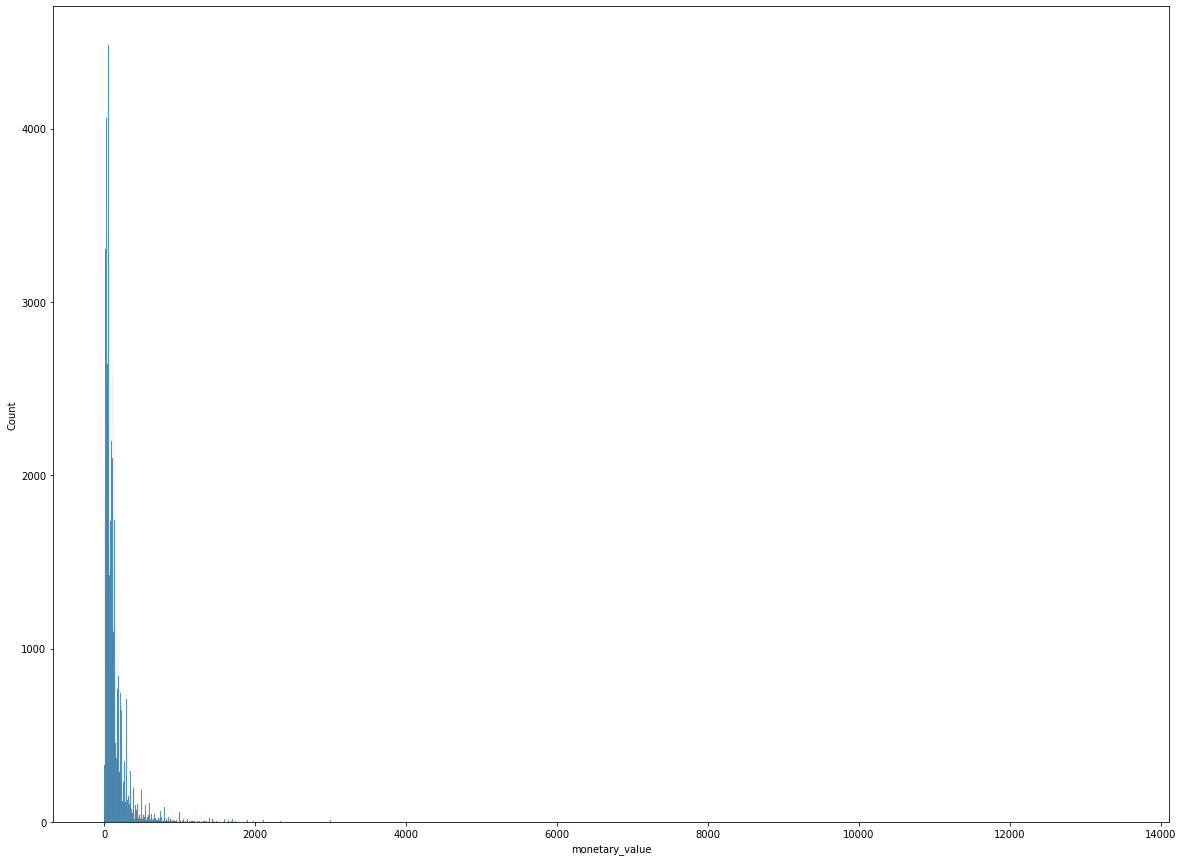

In [144]:
# длинный хвост вправо у распределения потраченных клиентом денег в разбивке по клиенту.
plt.figure(figsize = (20, 15))
sns.histplot(rfmSegmentation.monetary_value)

есть строки, где price отображается как NaN и автоматически при группировке пошло как 0. Считаю, что данные не стоит выкидывать, т.к у нас эти заказы значатся в frequency. Все NaN в price из заказов со статусом "unavailable" 

In [145]:
rfmSegmentation.query('monetary_value == 0').shape[0]

32

In [146]:
rfmSegmentation.query('monetary_value == 0')

,recency,frequency,monetary_value
customer_unique_id,,,
07a47aaed3703199835441d912aa3c43,74,1,0.0
083b13e0a35dd186fb89c345d9beacac,81,1,0.0
0c39cc8984e30ac517c69a6671be71a7,74,1,0.0
1ff3b4e02a84ba7bd1bd2a65bc330514,149,1,0.0
24aa3d9034dd158d598b5fbb388f9bb3,57,1,0.0
33e79e15e9937ba1bc8f61eedae9e7f0,74,1,0.0
36e06ca722231b14a75e6a33ffaa5f37,112,1,0.0
3eadc791253552b8fd96e5f63b403c8f,81,1,0.0
48aa83248476ac4d2b058596436b7680,76,1,0.0


#### Создам функцию, где каждый из трех параметров будет оцениваться от 1-4 (4 - лучший результат)

In [147]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

##### Запишем в переменную квантили по трем параментам. Видим, что в frequaency из-за слишком часто встречающихся покупок одного товара, единица и в q = 0.25 и в 0.75. Нас это не устраивает

In [148]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75]) # в целом такое разделение подойдет, кроме frequency!
quantiles

,recency,frequency,monetary_value
0.25,162.0,1.0,47.65
0.50,266.0,1.0,89.70
0.75,394.0,1.0,154.86


посмотрим value_counts, что бы оценить, как "бить" данные

In [149]:

rfmSegmentation.frequency.value_counts()

1     82074
2      8820
3      1648
4       622
5       241
6       190
7        45
8        16
10       11
11       11
9        10
12        9
14        3
15        3
13        2
20        2
21        1
18        1
24        1
Name: frequency, dtype: int64

стоит отнести в группу 1 всех, кто купил один товар (очень большая группа), в группу 2 - кто купил от 2-7 вещей,
в группу 3 - 8-13, в группу 4 - 14, 15, 18, 20, 21, 24

In [150]:
quantiles['true_frequency'] = [1.0, 7.0, 13.0]
quantiles

,recency,frequency,monetary_value,true_frequency
0.25,162.0,1.0,47.65,1.0
0.50,266.0,1.0,89.70,7.0
0.75,394.0,1.0,154.86,13.0


применим функцию и завершим RFM-анализ

In [151]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('true_frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)                             + rfmSegmentation.F_Quartile.map(str)                             + rfmSegmentation.M_Quartile.map(str)

In [152]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.90,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.90,3,1,1,311
0000f46a3911fa3c0805444483337064,586,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,337,1,180.00,2,1,4,214
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,2,1570.00,1,2,4,124
fffea47cd6d3cc0a88bd621562a9d061,311,1,64.89,2,1,2,212
ffff371b4d645b6ecea244b27531430a,617,1,89.90,1,1,3,113


In [153]:
rfmSegmentation.RFMClass.value_counts()

411    5694
111    5693
212    5605
311    5602
211    5441
112    5358
412    5284
413    5246
313    5156
312    5131
213    5004
113    4901
114    4606
214    4501
414    4467
314    4385
424    1448
324    1410
224    1338
124    1206
223     846
323     806
423     756
123     708
122     538
422     525
222     517
322     456
121     288
321     254
421     237
221     233
334      20
234      19
434      15
344       4
134       3
444       2
244       2
144       2
133       1
432       1
141       1
Name: RFMClass, dtype: int64

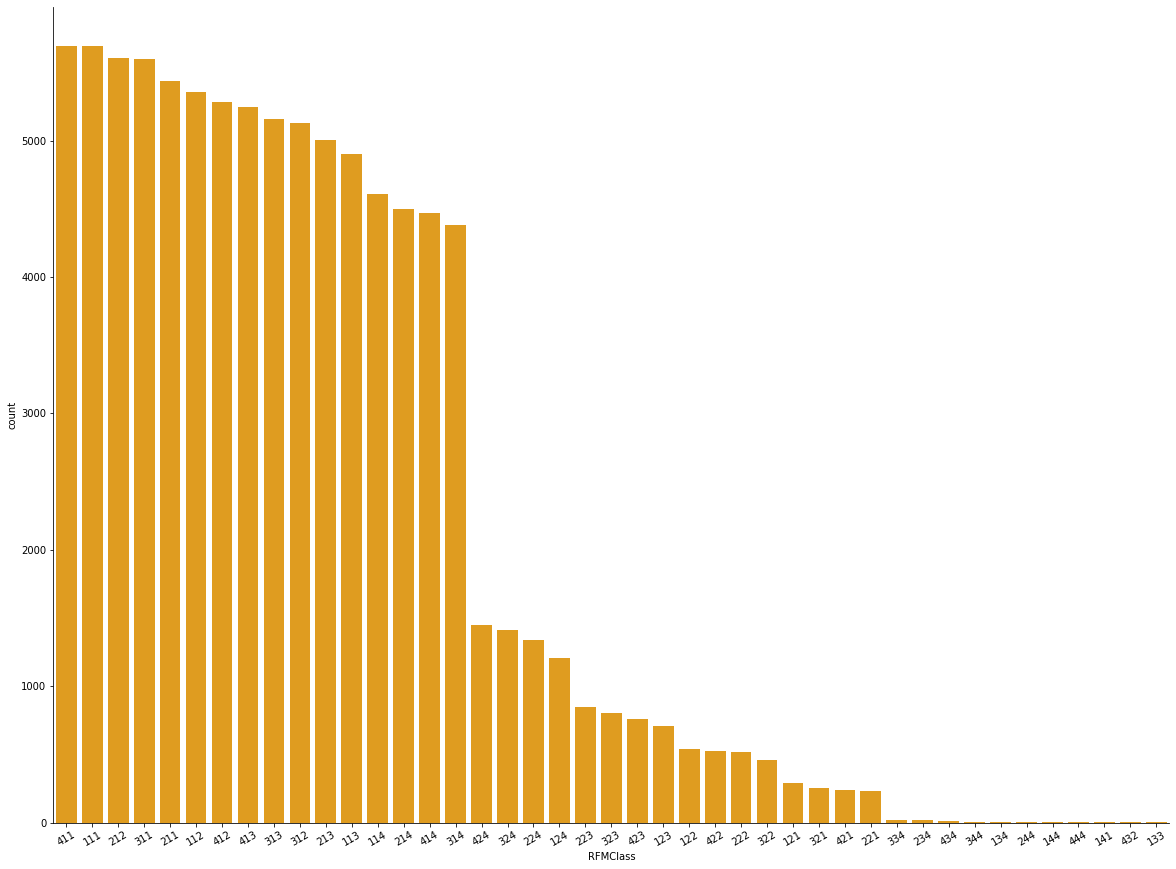

In [154]:
For_barplot = rfmSegmentation.groupby('RFMClass', as_index = False) \
                   .agg(count = ('frequency', 'count')).sort_values('count', ascending = False)
plt.figure(figsize = (20, 15))
ax = sns.barplot(data = For_barplot, x = 'RFMClass', y = 'count', \
                  color='orange', alpha= 1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
sns.despine()

## Вывод по 6-ому заданию:

## У нас достаточно много пользователей, совершивших покупку недавно, однако они покупают один товар и на маленькую сумму. При этом, "недавно" - понятие относительное, поскольку 162 дней - срок, ниже которого лежит 25% наблюдений. Очень много худшего типа покупателей (111). Самая большая проблема, как мне видится - малое количество приобретенных товаров клиентами. Только на 17-ом месте по числу пользователей стоит первый встреченный тип, купивший более одного продукта (и не более 7-ми).